<a href="https://colab.research.google.com/github/Bio-MingChen/DL_practice_by_Colab/blob/main/pytorch_test_20250806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms
import torch.nn.functional as F

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [41]:
training_data = datasets.MNIST(root="data",train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data",train=False,download=True,transform=transforms.ToTensor())
train_loader = DataLoader(training_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=True)
baches = len(train_loader)
size = len(training_data)
print(f"The size of training data is {size}",f"The size of test data is {len(test_data)}",f"The size of batch is {baches}",sep="\n")

The size of training data is 60000
The size of test data is 10000
The size of batch is 938


In [43]:

training_data[0][0].shape

torch.Size([1, 28, 28])

In [46]:
def conv2d_output_size(H_in,W_in,kernel_size,stride=1,padding=0,dilation=1):
  """
    ËÆ°ÁÆó Conv2D ËæìÂá∫ÂõæÂÉèÁöÑÂ∞∫ÂØ∏

    ÂèÇÊï∞Ôºö
        H_in, W_in: ËæìÂÖ•ÂõæÂÉèÁöÑÈ´òÂíåÂÆΩ
        kernel_size: Âç∑ÁßØÊ†∏Â§ßÂ∞èÔºàint Êàñ tupleÔºâ
        stride: Ê≠•ÈïøÔºàint Êàñ tupleÔºâ
        padding: Â°´ÂÖÖÔºàint Êàñ tupleÔºâ
        dilation: ËÜ®ËÉÄÔºàÈªòËÆ§‰∏∫ 1Ôºâ

    ËøîÂõûÔºö
        H_out, W_out: ËæìÂá∫ÂõæÂÉèÁöÑÈ´òÂíåÂÆΩ
    """
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  if isinstance(stride, int):
    stride = (stride, stride)
  if isinstance(padding, int):
    padding = (padding, padding)
  if isinstance(dilation, int):
    dilation = (dilation, dilation)

  H_out = ((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0]) + 1
  W_out = ((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1]) + 1
  return H_out, W_out

def pool2d_output_size(H_in, W_in, kernel_size, stride=None, padding=0):
  """
  ËÆ°ÁÆóÊ±†ÂåñÂ±ÇÔºàMaxPool2DÔºâËæìÂá∫ÂõæÂÉèÂ∞∫ÂØ∏

  ÂèÇÊï∞Ôºö
      H_in, W_in: ËæìÂÖ•ÂõæÂÉèÁöÑÈ´òÂíåÂÆΩ
      kernel_size: Ê±†ÂåñÊ†∏Â§ßÂ∞èÔºàint Êàñ tupleÔºâ
      stride: Ê≠•ÈïøÔºàint Êàñ tupleÔºåÈªòËÆ§Á≠â‰∫é kernel_sizeÔºâ
      padding: Â°´ÂÖÖÔºàint Êàñ tupleÔºâ

  ËøîÂõûÔºö
      H_out, W_out: ËæìÂá∫ÂõæÂÉèÁöÑÈ´òÂíåÂÆΩ
  """
  if stride is None:
    stride = kernel_size
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  if isinstance(stride, int):
    stride = (stride, stride)
  if isinstance(padding, int):
    padding = (padding, padding)

  H_out = ((H_in + 2 * padding[0] - kernel_size[0]) // stride[0]) + 1
  W_out = ((W_in + 2 * padding[1] - kernel_size[1]) // stride[1]) + 1
  return H_out, W_out

class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.H, self.W = self._get_output_size()
    # encoder
    self.conv1 = nn.Conv2d(1,16,3,stride=1,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,stride=1,padding=1)
    self.maxpool = nn.MaxPool2d(2,stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32 * self.H * self.W,128)
    self.fc21 = nn.Linear(128,20)
    self.fc22 = nn.Linear(128,20)
    self.bn1 = nn.BatchNorm2d(16)
    self.bn2 = nn.BatchNorm2d(32)
    # self.dropout1 = nn.Dropout(0.25)
    # self.dropout2 = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

    #decoder
    self.defc1 = nn.Linear(20,128)
    self.defc2 = nn.Linear(128,32* self.H * self.W)
    self.upconv = nn.ConvTranspose2d(32,32,2,stride=2) # ‰∏äÈááÊ†∑ 14x14 -> 28x28
    self.deconv1 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
    self.deconv2 = nn.Conv2d(16, 1, 3, stride=1, padding=1)

  def _get_output_size(self):
    H, W = 28 , 28
    H, W = conv2d_output_size(H, W, 3, 1, 1)
    H, W = conv2d_output_size(H, W, 3, 1, 1)
    H, W = pool2d_output_size(H, W, 2, 2)
    print(f"ÊúÄÁªàÂõæÁâáÂ§ßÂ∞èÔºö{H} x {W}")

    return H, W

  def encoder(self,x):
    x = self.bn1(self.conv1(x))
    x = self.relu(x)
    x = self.bn2(self.conv2(x))
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    # x = self.dropout1(x)
    x = self.fc1(x)
    x = self.relu(x)
    # x = self.dropout2(x)
    mu = self.fc21(x)
    logvar = self.fc22(x)

    return mu, logvar

  def reparameterize(self,mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return std * eps + mu

  def decoder(self,z):
    x = self.defc1(z)
    # x = self.relu(x)
    # x = self.dropout2(x)
    x = self.defc2(x)
    # x = self.relu(self.defc2(x))
    # x = self.dropout1(x)
    x = x.view(-1, 32, self.H, self.W)
    x = self.upconv(x)
    x = self.deconv1(x)
    # x = self.relu(self.deconv1(x))
    x = self.deconv2(x)
    # x = self.relu(self.deconv2(x))
    x = self.sigmoid(x)
    return x

  def forward(self,x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    recon_x = self.decoder(z)
    return recon_x, mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

ÊúÄÁªàÂõæÁâáÂ§ßÂ∞èÔºö14 x 14


In [35]:
# https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 2, 2)

class VAE(nn.Module):
    def __init__(self, image_channels=1, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 3, stride=2, padding=1),  # 28 ‚Üí 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14 ‚Üí 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 7 ‚Üí 4
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 4 ‚Üí 2
            nn.ReLU(),
            Flatten(),  # (B, 256*2*2 = 1024)
        )

        h_dim = 256 * 2 * 2
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),  # ‚Üí (B, 256, 2, 2)
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 2‚Üí4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 4‚Üí8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 8‚Üí16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),     # 16‚Üí32
            nn.Sigmoid(),  # [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        return self.bottleneck(h)

    def decode(self, z):
        h = self.fc3(z)
        return self.decoder(h)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x[:, :, 2:30, 2:30], mu, logvar  # crop to 28x28

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [56]:
# recurrent code
from torchvision.transforms.functional import center_crop

class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, 3, 2, 1),
        nn.ReLU(),
        nn.Flatten()
    )
    self.fc11 = nn.Linear(256 * 2 * 2, 20)
    self.fc12 = nn.Linear(256 * 2 * 2, 20)
    self.fc2 = nn.Linear(20, 256 * 2 * 2)

    self.decoder = nn.Sequential(
        nn.Unflatten(1, (256, 2, 2)),
        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, 4, 2, 1),
        nn.Sigmoid(),

    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps

  def bottleneck(self, h):
    mu = self.fc11(h)
    logvar = self.fc12(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self,x):
    h = self.encoder(x)
    # print(f"‚ö†Ô∏è encoder output shape: {h.shape}")
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

  def decode(self,z):
    z = self.fc2(z)
    recon_x = self.decoder(z)
    return recon_x

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    recon_x = self.decode(z)
    recon_x = center_crop(recon_x, [28, 28])  # ‚úÖ ‰øÆÂ§çÊñπÂºè
    return recon_x, mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 2, 2]         295,168
              ReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                   [-1, 20]          20,500
           Linear-11                   [-1, 20]          20,500
           Linear-12                 [-1, 1024]          21,504
        Unflatten-13            [-1, 256, 2, 2]               0
  ConvTranspose2d-14            [-1, 12

In [45]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + beta * KLD

ÂΩìÁÑ∂ÂèØ‰ª•ÔºÅKL Êï£Â∫¶ÔºàKullback-Leibler divergenceÔºåKL divergenceÔºâÊòØÂèòÂàÜËá™ÁºñÁ†ÅÂô®ÔºàVAEÔºâ‰∏≠ÁöÑÊ†∏ÂøÉÁªÑÊàêÈÉ®ÂàÜ‰πã‰∏ÄÔºåÁî®‰∫éË°°Èáè‰∏§‰∏™ÂàÜÂ∏É‰πãÈó¥ÁöÑÂ∑ÆÂºÇ„ÄÇ‰∏ãÈù¢Êàë‰ºö‰ªéÁõ¥ËßÇËß£Èáä„ÄÅÊï∞Â≠¶ÂÖ¨Âºè„ÄÅÂú® VAE ‰∏≠ÁöÑÂÖ∑‰ΩìËÆ°ÁÆóÊñπÊ≥ï‰∏âÈÉ®ÂàÜÂ∏Æ‰Ω†ÂΩªÂ∫ïÁêÜËß£ÂÆÉÔºö

---

## üß† ‰∏Ä„ÄÅKL Êï£Â∫¶ÊòØÂï•ÔºüÔºàÁõ¥ËßÇÁêÜËß£Ôºâ

KL Êï£Â∫¶Ë°°ÈáèÁöÑÊòØÔºö

> **‚ÄúÁõÆÊ†áÂàÜÂ∏É‚Äù Âíå ‚ÄúÂèÇËÄÉÂàÜÂ∏É‚Äù ‰πãÈó¥ÊúâÂ§öËøú**ÔºåÂç≥Ôºö
> Â¶ÇÊûú‰Ω†Áî®ÂèÇËÄÉÂàÜÂ∏É $Q(z)$ Êù•Ëøë‰ººÁõÆÊ†áÂàÜÂ∏É $P(z)$Ôºå‰Ω†Ë¶Å‰ªòÂá∫Â§öÂ§ß‰ª£‰ª∑Ôºü

Âú® VAE ‰∏≠Ôºö

* ÁúüÂÆû‰ΩÜ‰∏çÂèØÁü•ÁöÑÂêéÈ™åÊòØÔºö$p(z|x)$Ôºà‰∏çÂèØÊ±ÇÔºâ
* Êàë‰ª¨Áî®‰∏Ä‰∏™ÂèØÂ≠¶‰π†ÁöÑËøë‰ººÂêéÈ™å $q(z|x) \sim \mathcal{N}(\mu, \sigma^2)$
* ÁõÆÊ†áÊòØËÆ© $q(z|x)$ Â∞ΩÂèØËÉΩË¥¥ËøëÊ†áÂáÜÊ≠£ÊÄÅÂàÜÂ∏É $p(z) = \mathcal{N}(0, I)$

ÊâÄ‰ª•Êàë‰ª¨ÊúÄÂ∞èÂåñÔºö

$$
\text{KL}(q(z|x) \parallel p(z))
$$

---

## üßÆ ‰∫å„ÄÅKL Êï£Â∫¶ÁöÑÊï∞Â≠¶ÂÖ¨ÂºèÔºàÈ´òÊñØ‰πãÈó¥Ôºâ

KL Êï£Â∫¶ÁöÑÈÄöÂºèÊòØÔºö

$$
\text{KL}(q \parallel p) = \int q(z) \log \frac{q(z)}{p(z)} \, dz
$$

‰ΩÜÂØπ‰∫é‰∏§‰∏™ **Â§öÁª¥È´òÊñØÂàÜÂ∏É**Ôºö

* $q(z|x) = \mathcal{N}(\mu, \sigma^2)$
* $p(z) = \mathcal{N}(0, 1)$

KL Êúâ‰∏Ä‰∏™**Ëß£ÊûêËß£**ÔºàË∂ÖÈáçË¶ÅÔºâÔºö

$$
\text{KL}(q(z|x) \parallel p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left( \mu_i^2 + \sigma_i^2 - \log \sigma_i^2 - 1 \right)
$$

ËøôÈáå $d$ ÊòØ latent Áª¥Â∫¶ÔºåÊØîÂ¶Ç 20„ÄÇ

---

## üîß ‰∏â„ÄÅVAE ‰∏≠ÁöÑ KL Êï£Â∫¶ËÆ°ÁÆóÔºàPyTorch‰ª£Á†ÅÔºâ

‰Ω†Âú®Ê®°Âûã‰∏≠ËæìÂá∫‰∫Ü `mu` Âíå `logvar`ÔºåÂØπÂ∫îÁöÑÊòØ $\mu$ Âíå $\log \sigma^2$„ÄÇ

ÈÇ£‰πà KL loss ÁöÑÂÆûÁé∞ÈÄöÂ∏∏Â¶Ç‰∏ãÔºö

```python
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
```

Ëß£ÈáäÔºö

| È°πÁõÆ                               | Âê´‰πâ                                             |
| -------------------------------- | ---------------------------------------------- |
| `logvar`                         | $\log \sigma^2$ÔºåÊ®°ÂûãÁõ¥Êé•ËæìÂá∫                         |
| `mu.pow(2)`                      | $\mu^2$                                        |
| `logvar.exp()`                   | $\sigma^2$                                     |
| `1 + logvar - mu¬≤ - exp(logvar)` | Â∞±ÊòØËß£ÊûêÂºè‰∏≠ÁöÑ $\sigma^2 + \mu^2 - \log \sigma^2 - 1$ |
| ÊÄª‰Ωì‰πò‰∏ä `-0.5`                      | ÂæóÂà∞ÊúÄÁªà KL ÂÄº                                      |

---

## üéØ Âõõ„ÄÅÂú® VAE ÁöÑËÆ≠ÁªÉ‰∏≠ÔºåÂÆåÊï¥ Loss ËøôÊ†∑ÂÜôÔºö

```python
def loss_function(recon_x, x, mu, logvar):
    # ÈáçÂª∫ËØØÂ∑ÆÔºàÈÄöÂ∏∏Áî® BCE Êàñ MSEÔºâ
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Êï£Â∫¶
    kl = kl_divergence(mu, logvar)
    
    return recon_loss + kl
```

---

## ‚úÖ ÊÄªÁªìË°®

| È°πÁõÆ                       | ÂÜÖÂÆπ                                                       |                                                              |
| ------------------------ | -------------------------------------------------------- | ------------------------------------------------------------ |
| KL Êï£Â∫¶‰ΩúÁî®                  | Á∫¶Êùü latent space ÂàÜÂ∏ÉÈù†ËøëÊ†áÂáÜÊ≠£ÊÄÅ                                 |                                                              |
| Âú® VAE ‰∏≠ÁöÑ‰∏§‰∏™ÂàÜÂ∏É             | ( q(z                                                    | x) = \mathcal{N}(\mu, \sigma^2) )Ôºå$p(z) = \mathcal{N}(0, I)$ |
| KL Ëß£ÊûêÂºè                   | $\frac{1}{2} \sum (\mu^2 + \sigma^2 - \log\sigma^2 - 1)$ |                                                              |
| ‰ª£Á†ÅÂÆûÁé∞                     | `-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())`    |                                                              |
| ‰∏é reconstruction loss ÂêàÁî® | ÂΩ¢Êàê VAE ÁöÑÊÄª lossÔºåËøõË°åÂèçÂêë‰º†Êí≠                                    |                                                              |

---

Â¶ÇÊûú‰Ω†ÊÑüÂÖ¥Ë∂£ÔºåÊàëËøòÂèØ‰ª•ËÆ≤ËÆ≤Ôºö

* KL Êï£Â∫¶Âíå mutual information ÁöÑÂÖ≥Á≥ª
* Œ≤-VAE ÊòØÊÄé‰πàÊîπ KL ÊùÉÈáçÁöÑ
* Â¶Ç‰ΩïÂÆûÁé∞ annealingÔºàKL warm-upÔºâ

‰Ω†ÊÉ≥‰∫ÜËß£Âì™‰∏ÄÂùóÔºü


In [13]:
import matplotlib.pyplot as plt

def comparison_plot(x, recon_x):
  n = min(x.size(0), 8)
  fig, ax = plt.subplots(2, n, figsize=(10,5))
  for i in range(n):
    ax[0, i].imshow(x[i].squeeze().cpu(), cmap="gray")
    ax[0, i].axis("off")

    ax[1, i].imshow(recon_x[i].squeeze().cpu(), cmap="gray")
    ax[1, i].axis("off")
  plt.tight_layout()
  plt.show()

def train(dataloader,model,loss_fn,optimizer,epoch):
  model.train()
  size = len(dataloader.dataset)
  train_loss = 0
  batches = len(dataloader)
  for batch, (X, _) in enumerate(dataloader):
    X = X.to(device)
    optimizer.zero_grad()
    recon_x, mu, logvar = model(X)
    beta = min(1.0, epoch / 10)
    loss = loss_fn(recon_x, X, mu, logvar, beta=beta)
    # loss = loss_fn(recon_x, X, mu, logvar)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch % 100 == 99:
      avg_loss = loss.item() / len(X)
      print(f"loss: {avg_loss:>7f}  [{batch * len(X):>5d}/{size:>5d}]")
  print(f"Epoch {epoch} train loss: {train_loss / size:.4f}")

def test(dataloader, model, loss_fn, epoch):
  model.eval()
  size = len(dataloader.dataset)
  batches = len(dataloader)
  test_loss = 0
  with torch.no_grad():
    for batch, (X, _) in enumerate(dataloader):
      X = X.to(device)
      recon_x, mu, logvar = model(X)
      loss = loss_fn(recon_x, X, mu, logvar)
      test_loss += loss.item()
      if batch == 0:
        comparison_plot(X, recon_x)
  avg_loss = test_loss / size
  print(f"Epoch {epoch} test loss: {avg_loss:.4f}")

Epoch 1
loss: 150.233627  [ 6336/60000]
loss: 121.755974  [12736/60000]
loss: 110.847664  [19136/60000]
loss: 108.188011  [25536/60000]
loss: 100.615128  [31936/60000]
loss: 103.770653  [38336/60000]
loss: 103.754395  [44736/60000]
loss: 93.379066  [51136/60000]
loss: 101.432487  [57536/60000]
Epoch 1 train loss: 117.4034


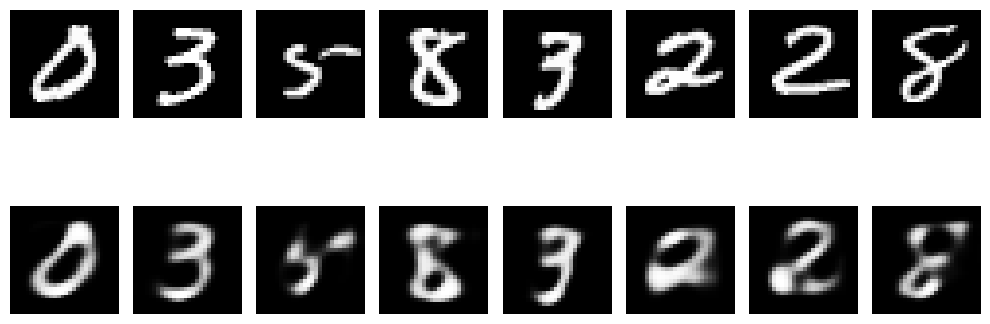

Epoch 1 test loss: 146.7876
Epoch 2
loss: 99.205215  [ 6336/60000]
loss: 95.474533  [12736/60000]
loss: 105.304688  [19136/60000]
loss: 95.111870  [25536/60000]
loss: 96.899628  [31936/60000]
loss: 98.471184  [38336/60000]
loss: 106.194412  [44736/60000]
loss: 98.174698  [51136/60000]
loss: 102.448555  [57536/60000]
Epoch 2 train loss: 99.6784


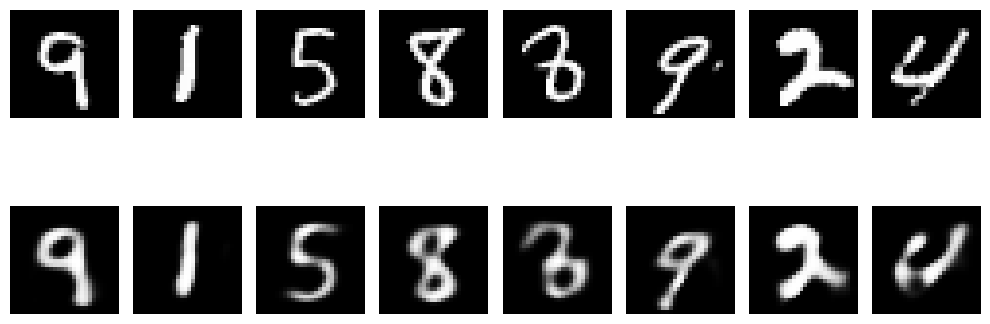

Epoch 2 test loss: 134.8104
Epoch 3
loss: 97.232185  [ 6336/60000]
loss: 103.255554  [12736/60000]
loss: 97.301895  [19136/60000]
loss: 99.322571  [25536/60000]
loss: 99.914726  [31936/60000]
loss: 99.046074  [38336/60000]
loss: 105.587914  [44736/60000]
loss: 97.978477  [51136/60000]
loss: 102.211304  [57536/60000]
Epoch 3 train loss: 102.2857


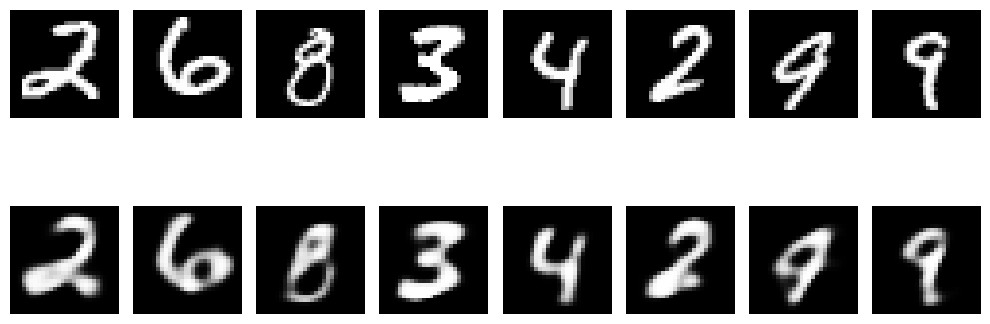

Epoch 3 test loss: 129.1088
Epoch 4
loss: 101.855492  [ 6336/60000]
loss: 112.102997  [12736/60000]
loss: 106.149071  [19136/60000]
loss: 109.019554  [25536/60000]
loss: 105.094193  [31936/60000]
loss: 104.955437  [38336/60000]
loss: 102.497612  [44736/60000]
loss: 105.714676  [51136/60000]
loss: 102.038330  [57536/60000]
Epoch 4 train loss: 104.0401


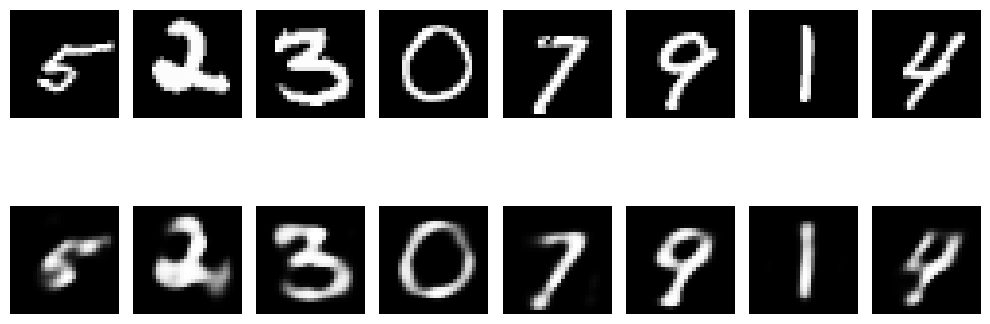

Epoch 4 test loss: 126.5518
Epoch 5
loss: 107.107025  [ 6336/60000]
loss: 108.338501  [12736/60000]
loss: 105.759964  [19136/60000]
loss: 109.189621  [25536/60000]
loss: 106.963074  [31936/60000]
loss: 108.227028  [38336/60000]
loss: 106.605515  [44736/60000]
loss: 107.885010  [51136/60000]
loss: 94.117477  [57536/60000]
Epoch 5 train loss: 107.3437


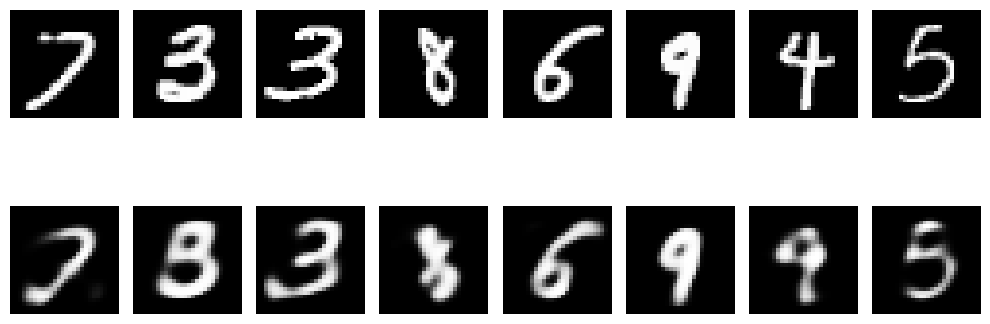

Epoch 5 test loss: 124.9741
Epoch 6
loss: 105.538597  [ 6336/60000]
loss: 108.104721  [12736/60000]
loss: 105.523125  [19136/60000]
loss: 110.205017  [25536/60000]
loss: 110.238564  [31936/60000]
loss: 109.552216  [38336/60000]
loss: 115.469193  [44736/60000]
loss: 105.354042  [51136/60000]
loss: 106.091255  [57536/60000]
Epoch 6 train loss: 110.6100


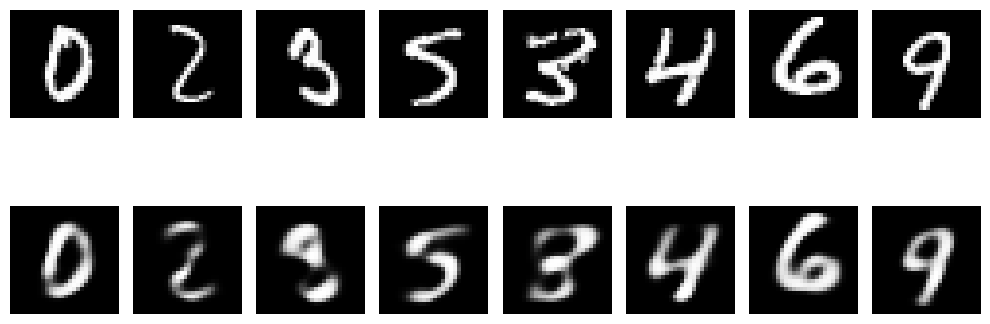

Epoch 6 test loss: 122.5957
Epoch 7
loss: 114.812546  [ 6336/60000]
loss: 121.516098  [12736/60000]
loss: 119.525757  [19136/60000]
loss: 114.547249  [25536/60000]
loss: 108.025490  [31936/60000]
loss: 109.143295  [38336/60000]
loss: 121.019417  [44736/60000]
loss: 113.401505  [51136/60000]
loss: 113.084511  [57536/60000]
Epoch 7 train loss: 113.6861


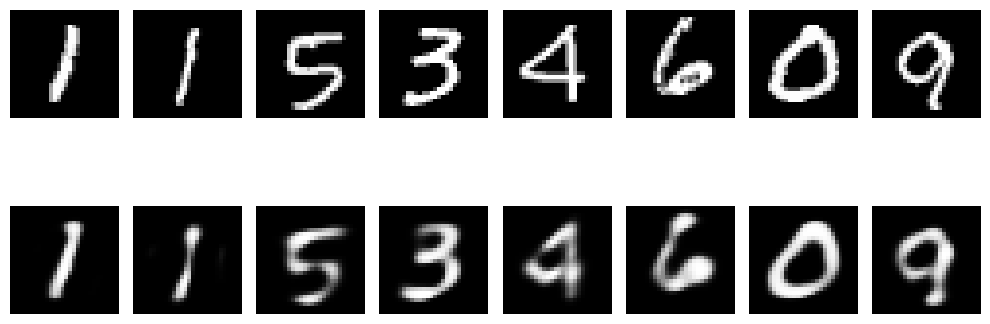

Epoch 7 test loss: 121.0484
Epoch 8
loss: 116.641769  [ 6336/60000]
loss: 116.026421  [12736/60000]
loss: 119.772751  [19136/60000]
loss: 119.790489  [25536/60000]
loss: 123.104172  [31936/60000]
loss: 123.417374  [38336/60000]
loss: 119.669617  [44736/60000]
loss: 113.373856  [51136/60000]
loss: 114.308701  [57536/60000]
Epoch 8 train loss: 116.5617


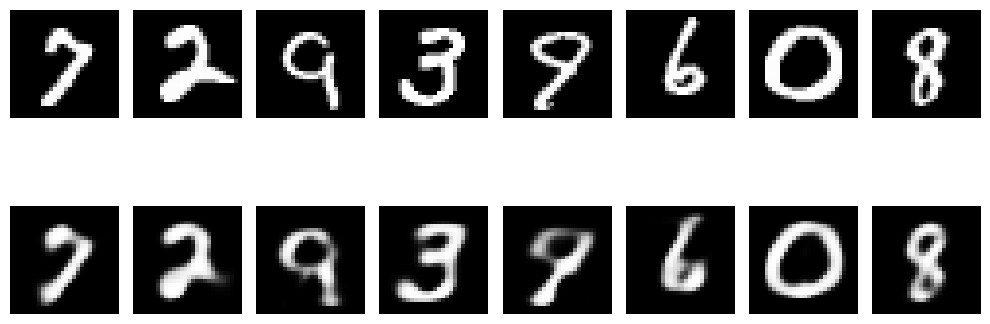

Epoch 8 test loss: 121.7776
Epoch 9
loss: 119.678169  [ 6336/60000]
loss: 117.044876  [12736/60000]
loss: 118.688866  [19136/60000]
loss: 117.877731  [25536/60000]
loss: 118.579163  [31936/60000]
loss: 116.755875  [38336/60000]
loss: 123.968422  [44736/60000]
loss: 127.103973  [51136/60000]
loss: 121.460358  [57536/60000]
Epoch 9 train loss: 119.4111


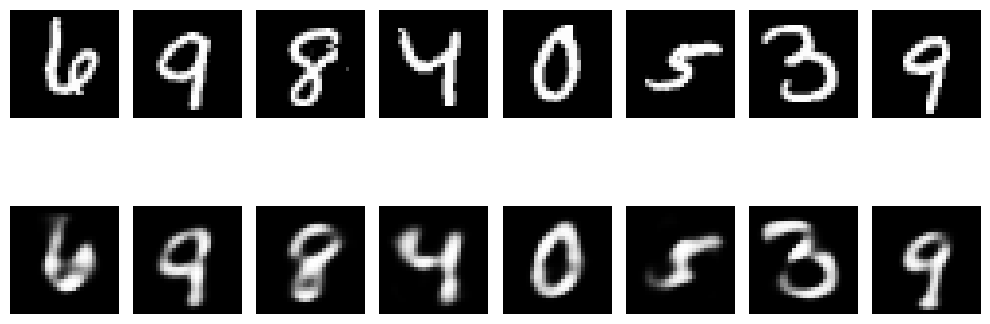

Epoch 9 test loss: 121.3532
Epoch 10
loss: 119.704468  [ 6336/60000]
loss: 125.018814  [12736/60000]
loss: 120.047409  [19136/60000]
loss: 118.150055  [25536/60000]
loss: 125.546532  [31936/60000]
loss: 124.631622  [38336/60000]
loss: 128.003021  [44736/60000]
loss: 121.393433  [51136/60000]
loss: 117.023232  [57536/60000]
Epoch 10 train loss: 121.9724


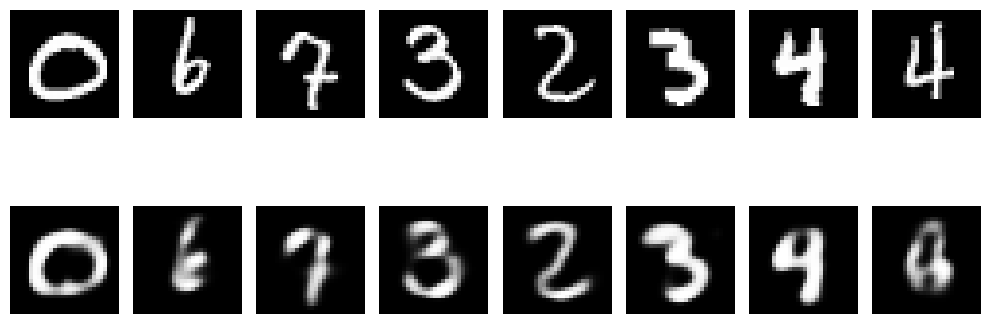

Epoch 10 test loss: 121.6183
Done


In [47]:
epochs = 10

for t in range(1, epochs+1):
  print(f"Epoch {t}\n =========================")
  train(train_loader,model,loss_function,optimizer,t)
  test(test_loader,model,loss_function,t)
print("Done")

Epoch 1
loss: 187.794907  [ 6336/60000]
loss: 135.172607  [12736/60000]
loss: 109.459213  [19136/60000]
loss: 98.737770  [25536/60000]
loss: 93.189125  [31936/60000]
loss: 89.721100  [38336/60000]
loss: 80.826355  [44736/60000]
loss: 79.827156  [51136/60000]
loss: 83.157967  [57536/60000]
Epoch 1 train loss: 119.2426


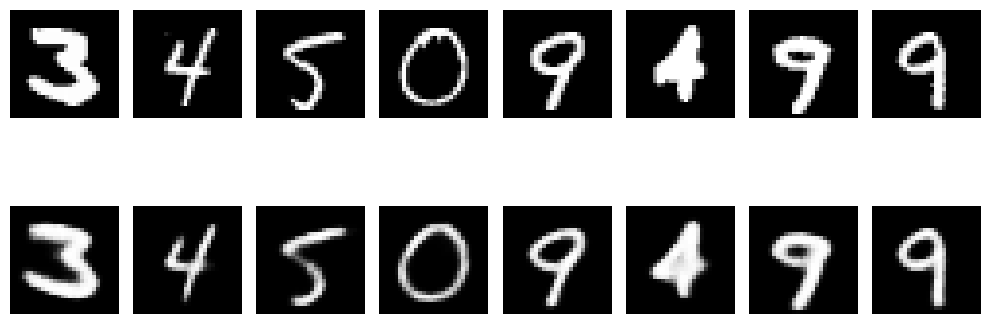

Epoch 1 test loss: 137.6220
Epoch 2
loss: 83.433678  [ 6336/60000]
loss: 78.541336  [12736/60000]
loss: 74.787285  [19136/60000]
loss: 84.036201  [25536/60000]
loss: 79.857002  [31936/60000]
loss: 80.607307  [38336/60000]
loss: 80.765907  [44736/60000]
loss: 73.452583  [51136/60000]
loss: 79.539337  [57536/60000]
Epoch 2 train loss: 81.2729


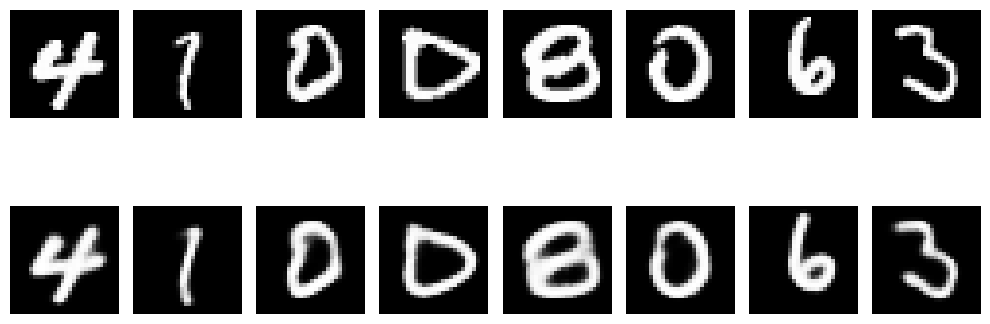

Epoch 2 test loss: 118.2887
Epoch 3
loss: 83.130913  [ 6336/60000]
loss: 83.475815  [12736/60000]
loss: 83.809227  [19136/60000]
loss: 80.921761  [25536/60000]
loss: 82.655022  [31936/60000]
loss: 79.870064  [38336/60000]
loss: 83.612946  [44736/60000]
loss: 79.840225  [51136/60000]
loss: 80.962990  [57536/60000]
Epoch 3 train loss: 81.7569


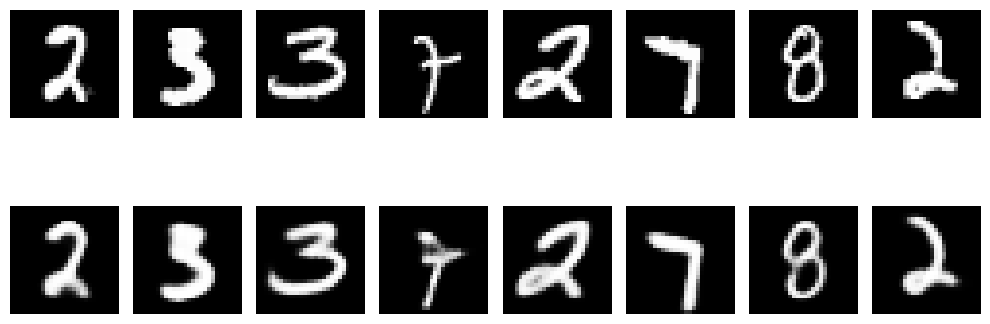

Epoch 3 test loss: 110.4562
Epoch 4
loss: 86.878365  [ 6336/60000]
loss: 85.851181  [12736/60000]
loss: 80.099503  [19136/60000]
loss: 84.587593  [25536/60000]
loss: 82.987617  [31936/60000]
loss: 81.455635  [38336/60000]
loss: 83.555191  [44736/60000]
loss: 79.638428  [51136/60000]
loss: 82.299515  [57536/60000]
Epoch 4 train loss: 84.1273


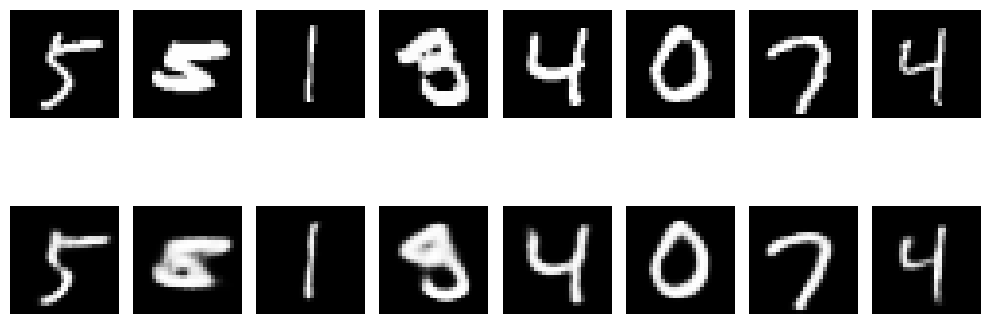

Epoch 4 test loss: 107.0977
Epoch 5
loss: 87.581886  [ 6336/60000]
loss: 85.000732  [12736/60000]
loss: 83.083702  [19136/60000]
loss: 87.361282  [25536/60000]
loss: 86.334343  [31936/60000]
loss: 87.713104  [38336/60000]
loss: 84.615463  [44736/60000]
loss: 83.017975  [51136/60000]
loss: 88.888954  [57536/60000]
Epoch 5 train loss: 86.9588


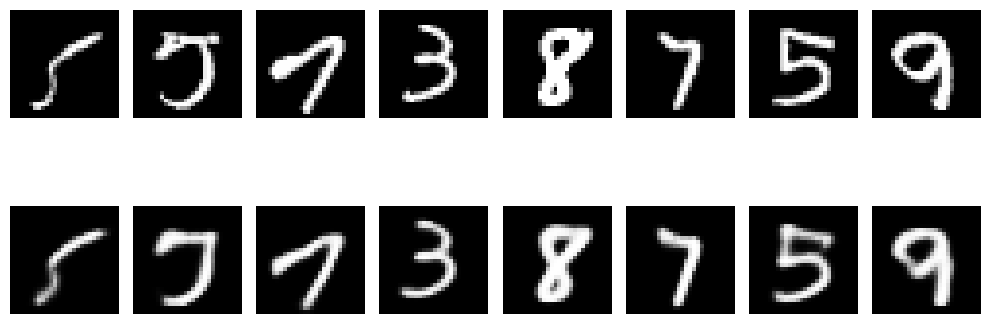

Epoch 5 test loss: 103.8148
Epoch 6
loss: 89.431190  [ 6336/60000]
loss: 88.416473  [12736/60000]
loss: 90.745453  [19136/60000]
loss: 92.630386  [25536/60000]
loss: 84.445663  [31936/60000]
loss: 85.421982  [38336/60000]
loss: 82.547020  [44736/60000]
loss: 87.899986  [51136/60000]
loss: 86.015350  [57536/60000]
Epoch 6 train loss: 89.5993


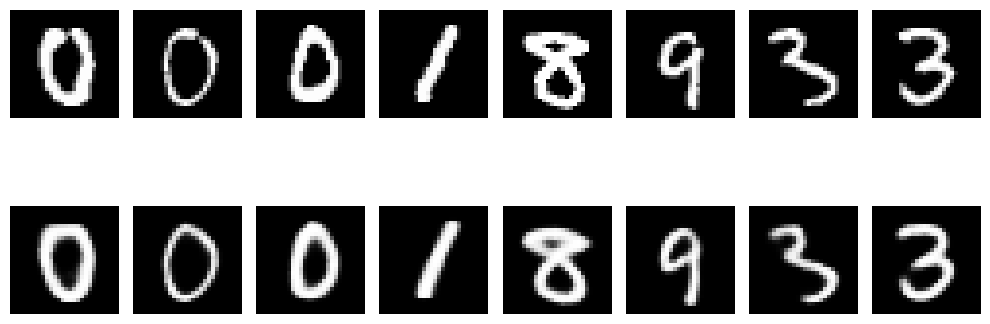

Epoch 6 test loss: 101.8082
Epoch 7
loss: 94.117165  [ 6336/60000]
loss: 96.225677  [12736/60000]
loss: 95.184235  [19136/60000]
loss: 92.271393  [25536/60000]
loss: 89.742416  [31936/60000]
loss: 90.170952  [38336/60000]
loss: 89.748489  [44736/60000]
loss: 89.506348  [51136/60000]
loss: 83.977829  [57536/60000]
Epoch 7 train loss: 92.1962


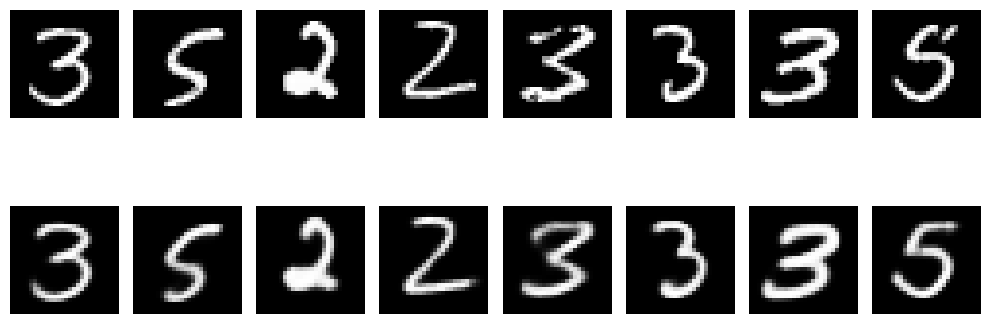

Epoch 7 test loss: 101.0347
Epoch 8
loss: 100.205460  [ 6336/60000]
loss: 97.618256  [12736/60000]
loss: 95.294525  [19136/60000]
loss: 95.805473  [25536/60000]
loss: 89.919991  [31936/60000]
loss: 95.843063  [38336/60000]
loss: 95.713326  [44736/60000]
loss: 95.199905  [51136/60000]
loss: 98.333893  [57536/60000]
Epoch 8 train loss: 94.6739


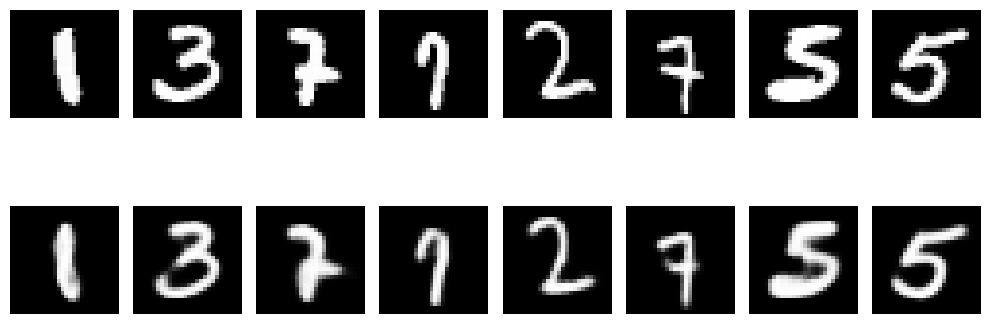

Epoch 8 test loss: 100.0420
Epoch 9
loss: 100.156616  [ 6336/60000]
loss: 93.483582  [12736/60000]
loss: 97.348305  [19136/60000]
loss: 95.683128  [25536/60000]
loss: 94.520744  [31936/60000]
loss: 99.634720  [38336/60000]
loss: 94.489380  [44736/60000]
loss: 96.920349  [51136/60000]
loss: 94.460197  [57536/60000]
Epoch 9 train loss: 96.8791


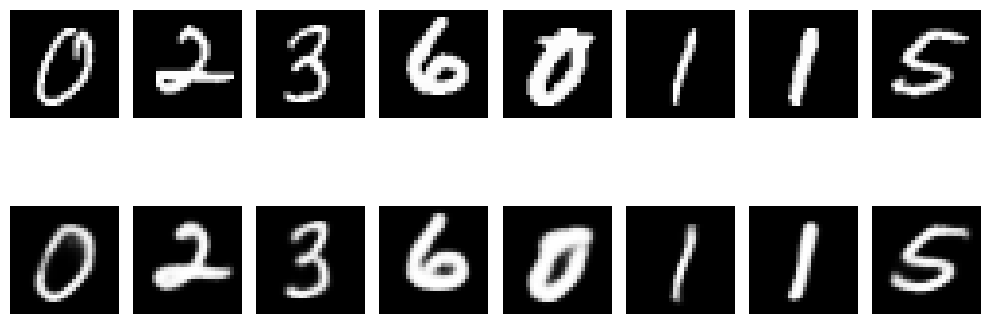

Epoch 9 test loss: 99.9171
Epoch 10
loss: 102.405106  [ 6336/60000]
loss: 98.022186  [12736/60000]
loss: 97.596260  [19136/60000]
loss: 103.012268  [25536/60000]
loss: 99.932472  [31936/60000]
loss: 97.946098  [38336/60000]
loss: 87.836517  [44736/60000]
loss: 99.149353  [51136/60000]
loss: 94.014061  [57536/60000]
Epoch 10 train loss: 99.1060


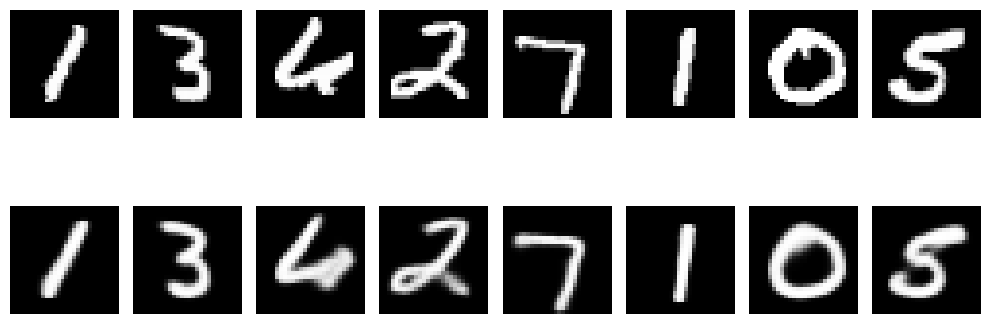

Epoch 10 test loss: 98.8422
Done


In [36]:
epochs = 10

for t in range(1, epochs+1):
  print(f"Epoch {t}\n =========================")
  train(train_loader,model,loss_function,optimizer,t)
  test(test_loader,model,loss_function,t)
print("Done")

Epoch 1
loss: 188.014465  [ 6336/60000]
loss: 144.756195  [12736/60000]
loss: 112.672829  [19136/60000]
loss: 104.354317  [25536/60000]
loss: 95.657898  [31936/60000]
loss: 86.429314  [38336/60000]
loss: 84.178253  [44736/60000]
loss: 81.570404  [51136/60000]
loss: 83.926376  [57536/60000]
Epoch 1 train loss: 119.5501


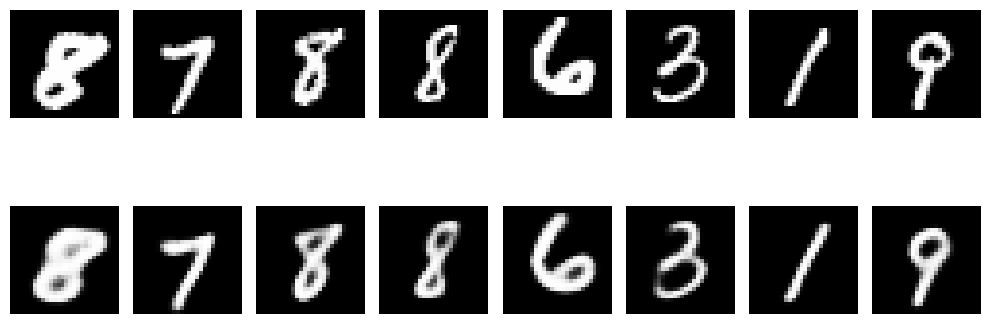

Epoch 1 test loss: 127.0146
Epoch 2
loss: 86.216446  [ 6336/60000]
loss: 87.124588  [12736/60000]
loss: 81.340248  [19136/60000]
loss: 77.195480  [25536/60000]
loss: 78.058693  [31936/60000]
loss: 76.689346  [38336/60000]
loss: 78.975159  [44736/60000]
loss: 77.179642  [51136/60000]
loss: 77.009575  [57536/60000]
Epoch 2 train loss: 80.5836


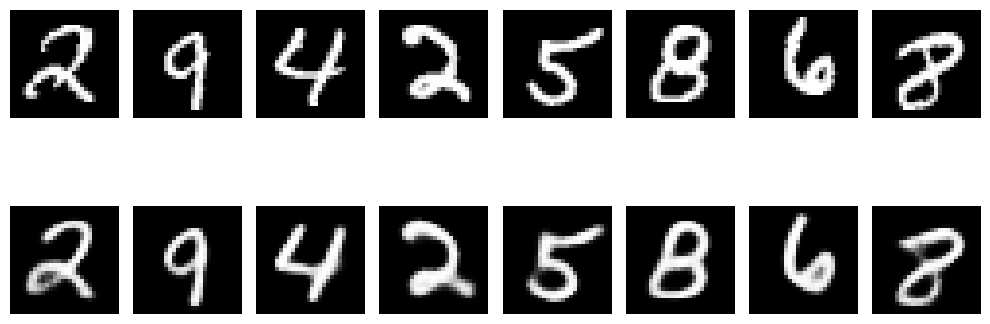

Epoch 2 test loss: 115.6291
Epoch 3
loss: 79.119080  [ 6336/60000]
loss: 81.368126  [12736/60000]
loss: 80.475128  [19136/60000]
loss: 85.089516  [25536/60000]
loss: 82.169968  [31936/60000]
loss: 81.519890  [38336/60000]
loss: 85.891975  [44736/60000]
loss: 84.779396  [51136/60000]
loss: 84.984589  [57536/60000]
Epoch 3 train loss: 81.8224


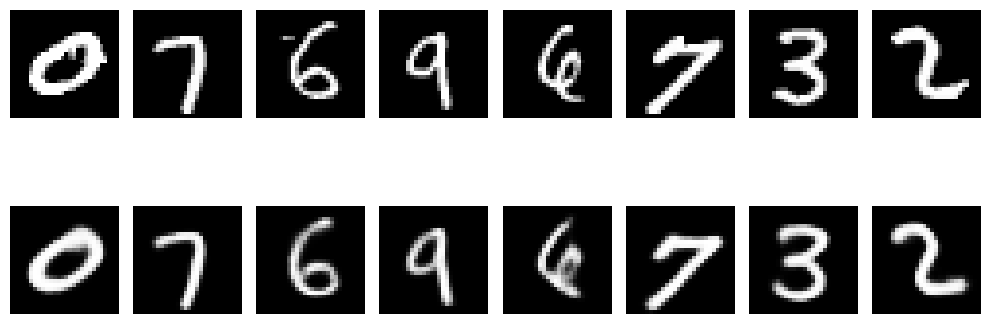

Epoch 3 test loss: 108.6225
Epoch 4
loss: 86.810371  [ 6336/60000]
loss: 81.492157  [12736/60000]
loss: 83.945023  [19136/60000]
loss: 82.855263  [25536/60000]
loss: 84.845078  [31936/60000]
loss: 83.308731  [38336/60000]
loss: 82.231842  [44736/60000]
loss: 83.305794  [51136/60000]
loss: 81.105019  [57536/60000]
Epoch 4 train loss: 84.3773


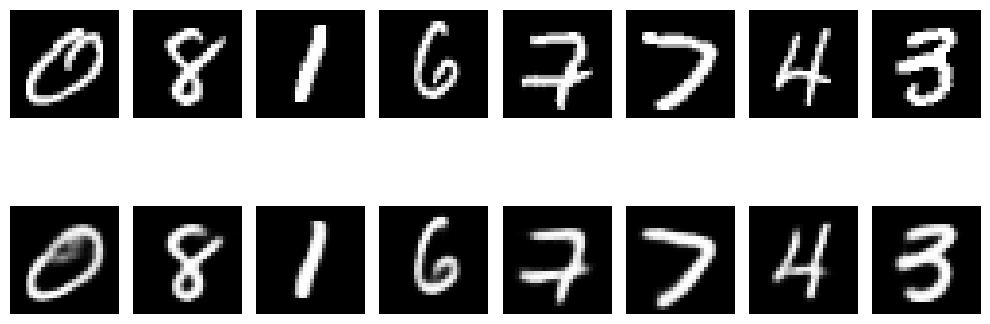

Epoch 4 test loss: 105.8857
Epoch 5
loss: 84.001701  [ 6336/60000]
loss: 85.867508  [12736/60000]
loss: 80.546265  [19136/60000]
loss: 84.261536  [25536/60000]
loss: 87.204865  [31936/60000]
loss: 85.186691  [38336/60000]
loss: 85.724106  [44736/60000]
loss: 86.119614  [51136/60000]
loss: 83.385437  [57536/60000]
Epoch 5 train loss: 87.0649


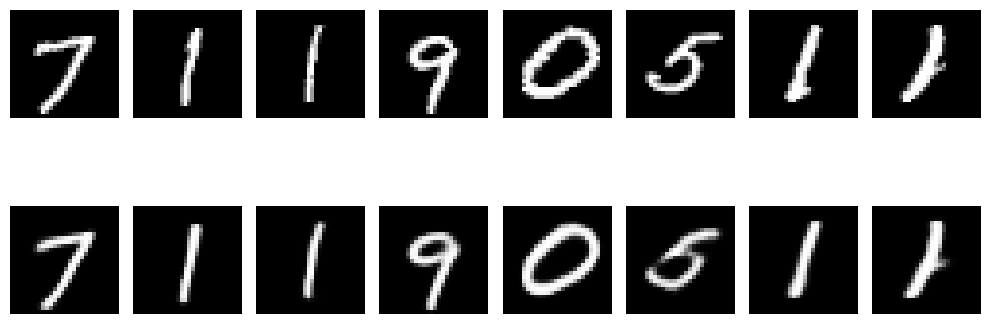

Epoch 5 test loss: 103.8739
Epoch 6
loss: 89.617447  [ 6336/60000]
loss: 91.950394  [12736/60000]
loss: 85.291672  [19136/60000]
loss: 87.941704  [25536/60000]
loss: 86.354103  [31936/60000]
loss: 87.311226  [38336/60000]
loss: 91.103111  [44736/60000]
loss: 91.249115  [51136/60000]
loss: 90.912842  [57536/60000]
Epoch 6 train loss: 89.5879


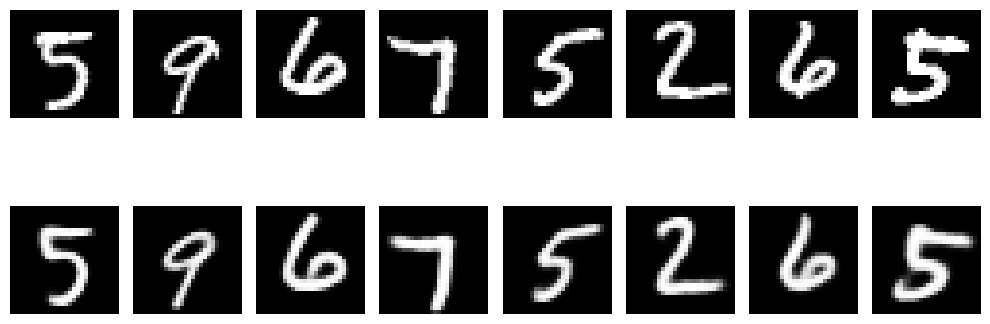

Epoch 6 test loss: 101.0737
Epoch 7
loss: 87.864220  [ 6336/60000]
loss: 91.143280  [12736/60000]
loss: 90.724899  [19136/60000]
loss: 89.614830  [25536/60000]
loss: 92.205444  [31936/60000]
loss: 89.002991  [38336/60000]
loss: 94.981056  [44736/60000]
loss: 88.478798  [51136/60000]
loss: 93.257759  [57536/60000]
Epoch 7 train loss: 91.9711


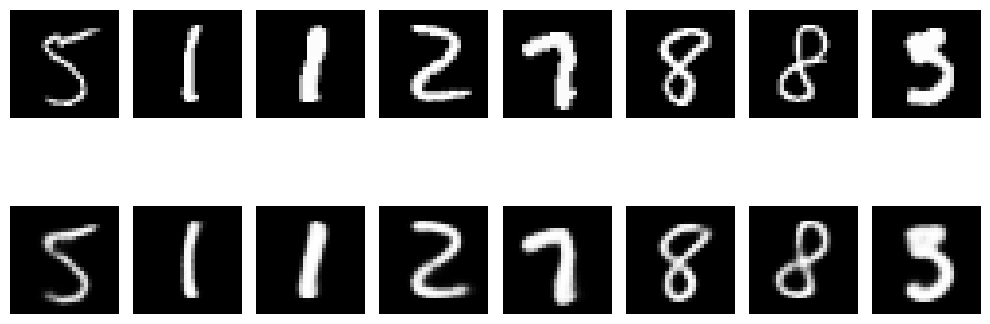

Epoch 7 test loss: 100.5025
Epoch 8
loss: 91.820648  [ 6336/60000]
loss: 92.174316  [12736/60000]
loss: 97.711067  [19136/60000]
loss: 95.096642  [25536/60000]
loss: 95.813782  [31936/60000]
loss: 94.984169  [38336/60000]
loss: 95.408638  [44736/60000]
loss: 91.996185  [51136/60000]
loss: 99.045258  [57536/60000]
Epoch 8 train loss: 94.3104


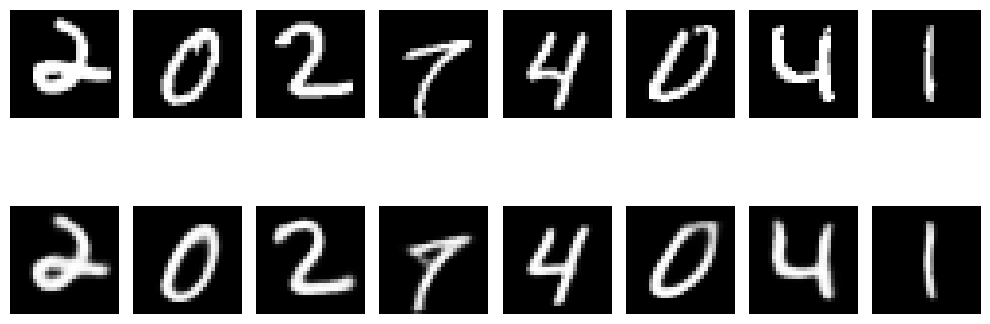

Epoch 8 test loss: 98.9966
Epoch 9
loss: 100.197784  [ 6336/60000]
loss: 101.108116  [12736/60000]
loss: 92.286880  [19136/60000]
loss: 99.169899  [25536/60000]
loss: 93.566246  [31936/60000]
loss: 98.884216  [38336/60000]
loss: 96.062561  [44736/60000]
loss: 97.326874  [51136/60000]
loss: 98.507553  [57536/60000]
Epoch 9 train loss: 96.5016


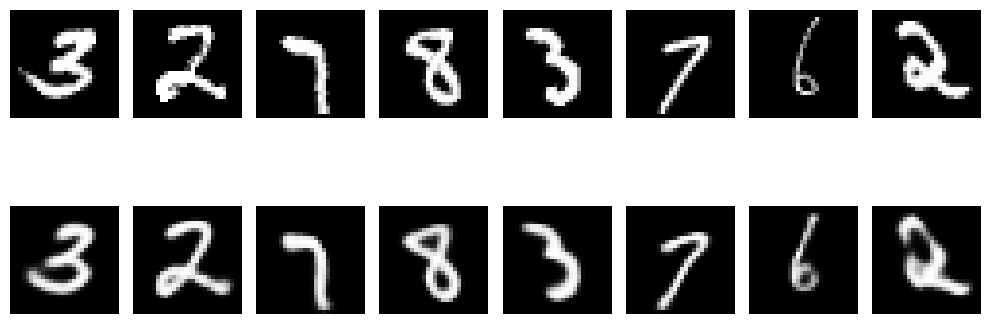

Epoch 9 test loss: 98.8528
Epoch 10
loss: 98.098419  [ 6336/60000]
loss: 102.241325  [12736/60000]
loss: 101.961052  [19136/60000]
loss: 100.043739  [25536/60000]
loss: 97.612846  [31936/60000]
loss: 98.813690  [38336/60000]
loss: 98.754845  [44736/60000]
loss: 93.195633  [51136/60000]
loss: 101.712204  [57536/60000]
Epoch 10 train loss: 98.6191


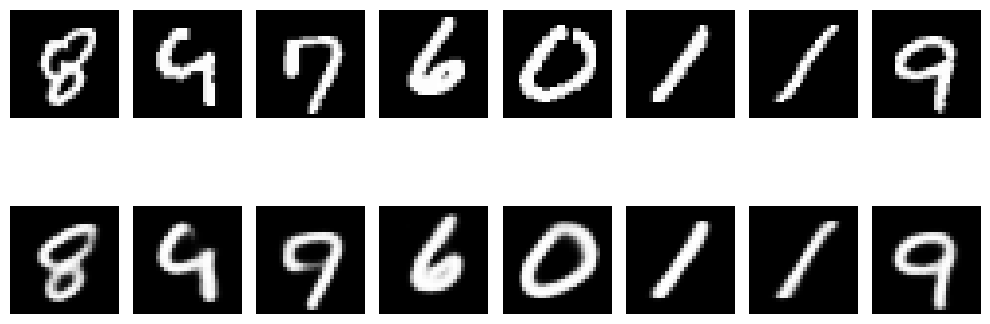

Epoch 10 test loss: 98.3938
Done


In [57]:
# recurrent code
epochs = 10

for t in range(1, epochs+1):
  print(f"Epoch {t}\n =========================")
  train(train_loader,model,loss_function,optimizer,t)
  test(test_loader,model,loss_function,t)
print("Done")

ÊòØÁöÑÔºåÁé∞Âú®Ëøô‰∏§‰∏™Á±ªÔºà`Flatten` Âíå `UnFlatten`ÔºâÂú® PyTorch ‰∏≠ÈÉΩ **Â∑≤ÁªèÂèØ‰ª•Áî®ÂÜÖÁΩÆÁöÑÊ†áÂáÜÂáΩÊï∞Êõø‰ª£**Ôºå‰∏çÈúÄË¶ÅÊâãÂä®ÂÆö‰πâ„ÄÇ

---

## ‚úÖ 1. Êõø‰ª£ `Flatten`

‰Ω†ÂèØ‰ª•‰ΩøÁî®Ôºö

```python
nn.Flatten()
```

Á≠â‰ª∑‰∫é‰Ω†Ëá™Â∑±ÂÜôÁöÑÔºö

```python
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
```

---

## ‚úÖ 2. Êõø‰ª£ `UnFlatten`

Â¶ÇÊûú‰Ω†Áü•ÈÅìÁõÆÊ†áÂΩ¢Áä∂ÔºàÂ¶Ç `(256, 2, 2)`ÔºâÔºåÂèØ‰ª•Áî®Ôºö

```python
nn.Unflatten(dim=1, unflattened_size=(256, 2, 2))
```

Á≠â‰ª∑‰∫éÔºö

```python
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 2, 2)
```

---

## ‚úÖ Á§∫‰æãÊõøÊç¢‰ª£Á†ÅÔºö

ÂéüÊù•Ôºö

```python
self.decoder = nn.Sequential(
    UnFlatten(),
    nn.ConvTranspose2d(256, 128, 4, 2, 1),
    ...
)
```

ÊõøÊç¢‰∏∫Ôºö

```python
self.decoder = nn.Sequential(
    nn.Unflatten(1, (256, 2, 2)),
    nn.ConvTranspose2d(256, 128, 4, 2, 1),
    ...
)
```

---

## üí° Ë°•ÂÖÖÂª∫ËÆÆÔºö

‰Ω†‰πüÂèØ‰ª•Âä®ÊÄÅËÆ∞ÂΩïÁºñÁ†ÅÂêéÁöÑÂΩ¢Áä∂ÔºåÂ¶ÇÔºö

```python
self.h_dim = 256 * 2 * 2  # Áî®‰∫é Linear ÁöÑ in_features
```

---

## ‚úÖ ÊÄªÁªì

| Ëá™ÂÆö‰πâÁ±ª        | Êõø‰ª£ÂÜôÊ≥ï                                              |
| ----------- | ------------------------------------------------- |
| `Flatten`   | `nn.Flatten()`                                    |
| `UnFlatten` | `nn.Unflatten(dim=1, unflattened_size=(C, H, W))` |

‰ΩøÁî®Ëøô‰∫õÂÜÖÁΩÆÊ®°ÂùóÂèØ‰ª•ËÆ©‰ª£Á†ÅÊõ¥ÁÆÄÊ¥Å„ÄÅÊõ¥Ê†áÂáÜÂåñÔºå‰πüÊñπ‰æøÂØºÂá∫‰∏∫ ONNX Á≠âÊ†ºÂºè„ÄÇ

ÊòØÂê¶ÈúÄË¶ÅÊàëÂ∏Æ‰Ω†ÊääÊï¥‰∏™Ê®°ÂûãÁªìÊûÑÂÅö‰∏ÄÊ¨°Ê†áÂáÜÂåñÊõøÊç¢Ôºü


In [24]:
def compute_conv_output_size(H_in, W_in, conv_layers):
    """
    ÊâìÂç∞Âπ∂ËøîÂõûÂ§öÂ±ÇÂç∑ÁßØÂêéÁöÑÂõæÂÉèÂ∞∫ÂØ∏„ÄÇ

    ÂèÇÊï∞:
        H_in, W_in (int): ËæìÂÖ•ÂõæÂÉèÁöÑÈ´òÂíåÂÆΩ
        conv_layers (list of tuples): ÊØèÂ±ÇÂç∑ÁßØÁöÑÂèÇÊï∞ÔºåÊ†ºÂºèÂ¶Ç‰∏ãÔºö
            [(in_channels, out_channels, kernel_size, stride, padding), ...]

    ËøîÂõû:
        H_out, W_out (int): ÊúÄÂêé‰∏ÄÂ±ÇÁöÑÂõæÂÉèÈ´òÂíåÂÆΩ
    """

    def calc_out(H, W, kernel_size, stride, padding, dilation=1):
        H_out = ((H + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1
        W_out = ((W + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1
        return H_out, W_out

    print(f"Input size: {H_in} x {W_in}")
    for i, (in_c, out_c, k, s, p) in enumerate(conv_layers):
        H_in, W_in = calc_out(H_in, W_in, k, s, p)
        print(f"After Conv Layer {i+1}: Channels={out_c}, Size={H_in} x {W_in}")

    return H_in, W_in

H, W = 28, 28
conv_layers = [
    (1, 32, 4, 2, 1),
    (32, 64, 4, 2, 1),
    (64, 128, 4, 2, 1),
    (128, 256, 4, 1, 1),
]

H_out, W_out = compute_conv_output_size(H, W, conv_layers)
print(f"Final output size: {H_out} x {W_out}")


Input size: 28 x 28
After Conv Layer 1: Channels=32, Size=14 x 14
After Conv Layer 2: Channels=64, Size=7 x 7
After Conv Layer 3: Channels=128, Size=3 x 3
After Conv Layer 4: Channels=256, Size=2 x 2
Final output size: 2 x 2


`nn.Unflatten(1, (256, 2, 2))` ÊòØ PyTorch ‰∏≠ÁöÑ‰∏Ä‰∏™Ê®°ÂùóÔºåÁî®Êù• **Êää‰∏ÄÁª¥ÁöÑ tensor ÊÅ¢Â§çÊàêÂ§öÁª¥Âº†ÈáèÔºàÂ∏∏Áî®‰∫éËß£Á†ÅÂô® decoder ‰∏≠Ôºâ**„ÄÇ

---

### üîç ÂÆÉÁöÑ‰ΩúÁî®ÊòØÔºö

Â∞ÜÂΩ¢Â¶Ç `(batch_size, 1024)` ÁöÑÂº†Èáè ‚Üí ÂèòÊàê `(batch_size, 256, 2, 2)` ÁöÑÂº†Èáè

---

### üìå ÂèÇÊï∞Ëß£ÈáäÔºö

```python
nn.Unflatten(dim, unflattened_size)
```

* `dim=1`ÔºöË°®Á§∫ÂØπÁ¨¨ 1 ‰∏™Áª¥Â∫¶ÔºàÂç≥ÂéüÊù•ÁöÑ feature ÂêëÈáèÔºâËøõË°å unflattenÔºà‰∏çÂåÖÊã¨ batch Áª¥Â∫¶Ôºâ„ÄÇ
* `unflattened_size=(256, 2, 2)`ÔºöË°®Á§∫Ë¶ÅÊääËøô‰∏ÄÁª¥ reshape Êàê `(256, 2, 2)`„ÄÇ

---

### üß† ‰∏æ‰∏™‰æãÂ≠ê

```python
import torch
from torch import nn

x = torch.randn(64, 1024)  # ÂÅáËÆæÊòØ‰∏Ä‰∏™ batch size ‰∏∫ 64Ôºåflatten ÂêéÁöÑËæìÂá∫
unflatten = nn.Unflatten(1, (256, 2, 2))  # ÊääÁ¨¨ 1 Áª¥ (1024) ËøòÂéüÊàê (256, 2, 2)
x_unflat = unflatten(x)

print(x_unflat.shape)  # ËæìÂá∫Ôºötorch.Size([64, 256, 2, 2])
```

---

### ‚úÖ Â∫îÁî®Âú∫ÊôØÔºà‰Ω†Áé∞Âú®ÁöÑ VAE decoderÔºâÔºö

ÈÄöÂ∏∏Âú® VAE ÁöÑ decoder ‰∏≠Ôºå‰Ω†‰ºöÂÖàÔºö

1. Áî® `Linear(z_dim ‚Üí 1024)` ÂæóÂà∞‰∏Ä‰∏™Â±ïÂπ≥ÂêëÈáèÔºõ
2. ÁÑ∂ÂêéÁî® `nn.Unflatten(1, (256, 2, 2))` ÊääÂÆÉËøòÂéüÊàêÂõæÂÉèÂΩ¢Áä∂Ôºõ
3. ÁÑ∂ÂêéÂÜçÁî® `ConvTranspose2d` ËøõË°å‰∏äÈááÊ†∑„ÄÇ

---

### üîÅ ÂØπÂ∫îÁöÑ flatten ÊòØÔºü

‰Ω†ÂèØ‰ª•Âú® encoder ‰∏≠ÁúãÂà∞Ôºö

```python
nn.Flatten()  # ‰ºöÊää (B, C, H, W) ‚Üí (B, C√óH√óW)
```

ËÄå decoder ‰∏≠ `nn.Unflatten()` ÂàöÂ•ΩÊòØÂÆÉÁöÑÈÄÜÊìç‰Ωú„ÄÇ

---

Â¶ÇÈúÄÔºåÊàë‰πüÂèØ‰ª•Â∏Æ‰Ω†Â∞ÅË£Ö‰∏ÄÂØπ `Flatten/Unflatten` Ê®°ÂùóÁî®‰∫é encoder/decoder ‰∏≠ÈÖçÂ•ó‰ΩøÁî®„ÄÇ


In [32]:
def generate_vae_architecture(input_size=(28, 28), num_layers=4, in_channels=1, base_channels=32):
    """
    Ëá™Âä®ÁîüÊàêÈÄÇÈÖç VAE ÁöÑ encoder/decoder ÂèÇÊï∞ÁªìÊûÑ„ÄÇ

    ÂèÇÊï∞:
        input_size (tuple): ËæìÂÖ•ÂõæÂÉèÂ§ßÂ∞è (H, W)
        num_layers (int): Âç∑ÁßØÂ±ÇÊï∞ÈáèÔºàencoder Âíå decoder ÈÉΩÊòØÂØπÁß∞ÁöÑÔºâ
        in_channels (int): ËæìÂÖ•ÂõæÂÉèÈÄöÈÅìÊï∞
        base_channels (int): Á¨¨‰∏ÄÂ±ÇÂç∑ÁßØËæìÂá∫ÈÄöÈÅìÊï∞Ôºà‰πãÂêéÊØèÂ±ÇÁøªÂÄçÔºâ

    ËøîÂõû:
        encoder_layers, decoder_layers, final_feature_shape
    """
    H, W = input_size
    encoder_layers = []
    decoder_layers = []
    channels = in_channels

    h, w = H, W
    for i in range(num_layers):
        out_channels = base_channels * (2 ** i)
        encoder_layers.append((channels, out_channels, 4, 2, 1))  # k=4, s=2, p=1

        # ËÆ°ÁÆóËæìÂá∫Â∞∫ÂØ∏
        h = (h + 2 * 1 - 1 * (4 - 1) - 1) // 2 + 1
        w = (w + 2 * 1 - 1 * (4 - 1) - 1) // 2 + 1
        channels = out_channels

    # ÁºñÁ†ÅÂêé flatten ÁöÑÂ∞∫ÂØ∏
    flatten_shape = (channels, h, w)
    h_fc = channels * h * w

    # decoder ÁöÑÂ±ÇÂèÇÊï∞
    decoder_channels = [base_channels * (2 ** i) for i in reversed(range(num_layers))]
    for i in range(num_layers):
        out_ch = decoder_channels[i+1] if i < num_layers - 1 else in_channels

        # decoder ÊØè‰∏ÄÂ±Ç ConvTranspose2d ÂèÇÊï∞
        decoder_layers.append((decoder_channels[i], out_ch, 4, 2, 1))

    return encoder_layers, decoder_layers, flatten_shape


In [33]:
enc, dec, shape = generate_vae_architecture(input_size=(28, 28), num_layers=4)

print("Encoder:")
for i, layer in enumerate(enc):
    print(f"Layer {i+1}: Conv2d({layer})")

print("\nDecoder:")
for i, layer in enumerate(dec):
    print(f"Layer {i+1}: ConvTranspose2d({layer})")

print("\nFlattened shape:", shape)


Encoder:
Layer 1: Conv2d((1, 32, 4, 2, 1))
Layer 2: Conv2d((32, 64, 4, 2, 1))
Layer 3: Conv2d((64, 128, 4, 2, 1))
Layer 4: Conv2d((128, 256, 4, 2, 1))

Decoder:
Layer 1: ConvTranspose2d((256, 128, 4, 2, 1))
Layer 2: ConvTranspose2d((128, 64, 4, 2, 1))
Layer 3: ConvTranspose2d((64, 32, 4, 2, 1))
Layer 4: ConvTranspose2d((32, 1, 4, 2, 1))

Flattened shape: (256, 1, 1)


Â•ΩÈóÆÈ¢òÔºÅ‰Ω†ÈóÆÁöÑÊòØÂÖ≥‰∫é CNN ÁöÑËæìÂÖ•„ÄÅÂç∑ÁßØÊ†∏„ÄÅËæìÂá∫ÈÄöÈÅìÊï∞‰πãÈó¥ÁöÑÂÖ≥Á≥ªÔºåËøôÂØπ‰∫éÊ∑±ÂÖ•ÁêÜËß£ CNN ÂæàÂÖ≥ÈîÆ„ÄÇ

Êàë‰ª¨Êù• **ÈÄêÊ≠•ÂâñÊûê‰Ω†ÁöÑ‰æãÂ≠ê**Ôºö

---

## üéØ ÈóÆÈ¢òÂ§çËø∞

> ÂØπ‰∫éÂ§ßÂ∞è‰∏∫ **`1√ó28√ó28`** ÁöÑÂõæÁâáÔºåÁªèËøáÂ¶Ç‰∏ãÂç∑ÁßØÊìç‰ΩúÔºö

```python
nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
```

‰Ω†ÊÉ≥ÈóÆÔºö

> ÊúÄÁªàËæìÂá∫ÁöÑ‚Äú16‰∏™3√ó3ÁöÑÂç∑ÁßØÊ†∏‚ÄùÊòØÊÄé‰πàÊù•ÁöÑÔºüÊØè‰∏ÄÂ±ÇÂà∞Â∫ïÂèëÁîü‰∫Ü‰ªÄ‰πàÔºü‰∏ã‰∏ÄÂ±ÇÊé•Êî∂ÁöÑÂà∞Â∫ïÊòØÂï•Ôºü

---

## ‚úÖ ÂÖàÊêûÊ∏ÖÊ•öÂç∑ÁßØÂ±ÇÁöÑÂêÑ‰∏™ÂèÇÊï∞Âê´‰πâ

```python
nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
```

| ÂèÇÊï∞                | Âê´‰πâ                           |
| ----------------- | ---------------------------- |
| `in_channels=1`   | ËæìÂÖ•ÂõæÂÉèÊúâ1‰∏™ÈÄöÈÅìÔºàÁÅ∞Â∫¶ÂõæÔºâ               |
| `out_channels=16` | ËØ•Âç∑ÁßØÂ±ÇÊúâ 16 ‰∏™‰∏çÂêåÁöÑÂç∑ÁßØÊ†∏ÔºàÊØè‰∏™‰∫ßÁîü‰∏Ä‰∏™ËæìÂá∫ÈÄöÈÅìÔºâ |
| `kernel_size=3`   | ÊØè‰∏™Âç∑ÁßØÊ†∏ÁöÑÂ∞∫ÂØ∏‰∏∫ 3√ó3                |
| `stride=2`        | ÊØèÊ¨°Âç∑ÁßØË∑®‰∏§Ê†ºÊªëÂä®                    |
| `padding=1`       | Âú®ÂõæÂÉèËæπÁºòË°•‰∏ÄÂúà 0Ôºå‰ΩøÂ∞∫ÂØ∏‰∏çÂ§™Âø´Áº©Â∞è          |

---

## üìê ËæìÂá∫Â∞∫ÂØ∏ÊÄé‰πàËÆ°ÁÆóÔºü

ËæìÂá∫Á©∫Èó¥Â∞∫ÂØ∏ÔºàÈ´òÂíåÂÆΩÔºâËÆ°ÁÆóÂÖ¨Âºè‰∏∫Ôºö

$$
\text{OutputSize} = \left\lfloor \frac{\text{InputSize} + 2 \cdot \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

ÂØπ‰∫é‰Ω†ÁöÑÊÉÖÂÜµÔºö

* ËæìÂÖ•Â∞∫ÂØ∏Ôºö`28 √ó 28`
* ËÆ°ÁÆóËæìÂá∫Â∞∫ÂØ∏Ôºö

  $$
  \left\lfloor \frac{28 + 2*1 - 3}{2} \right\rfloor + 1 = \left\lfloor \frac{27}{2} \right\rfloor + 1 = 13 + 1 = 14
  $$

üîπ ÊâÄ‰ª•ËæìÂá∫Â∞∫ÂØ∏ÊòØ `16 √ó 14 √ó 14`

---

## üîç ÊØè‰∏™Âç∑ÁßØÊ†∏Âà∞Â∫ïÊòØÂï•Ôºü

‰Ω†ÂÜôÁöÑÔºö

> ÂæóÂà∞‰∫Ü 16 ‰∏™ 3√ó3 ÁöÑÂç∑ÁßØÊ†∏ÂòõÔºü

ÂÖ∂ÂÆûÊòØÔºö

### ‚úÖ Êúâ 16 ‰∏™**ËæìÂá∫ÈÄöÈÅì**ÔºåÊØè‰∏™ÈÄöÈÅìÁî±‰∏Ä‰∏™**Áã¨Á´ãÁöÑÂç∑ÁßØÊ†∏ÁªÑ**ÁîüÊàêÔºö

* Âõ†‰∏∫‰Ω†ËæìÂÖ•ÊòØ `in_channels=1`ÔºåÊâÄ‰ª•Ôºö

  * ÊØè‰∏™ËæìÂá∫ÈÄöÈÅìÂè™ÈúÄË¶Å‰∏Ä‰∏™ `3√ó3√ó1` ÁöÑÂç∑ÁßØÊ†∏
* ÊâÄ‰ª•‰Ω†ÊúâÔºö

  * **16 ‰∏™Â§ßÂ∞è‰∏∫ 3√ó3 ÁöÑÂç∑ÁßØÊ†∏**

ÁªìÊûúÊòØÔºö

> ÂØπËæìÂÖ•ÂõæÂÉèÁöÑÊØè‰∏™Âå∫ÂüüÔºåÁî®Ëøô 16 ‰∏™‰∏çÂêåÁöÑÂç∑ÁßØÊ†∏ÊªëÂä®Êâ´‰∏ÄÈÅçÔºåÂàÜÂà´ÂæóÂà∞‰∏Ä‰∏™ `14√ó14` ÁöÑÁâπÂæÅÂõæ„ÄÇÂÖ±ËæìÂá∫ `16 √ó 14 √ó 14` ÁöÑÂº†Èáè„ÄÇ

---

## üß† ‰∏ã‰∏ÄÂ±ÇÊé•Êî∂ÁöÑÊòØ‰ªÄ‰πàÔºü

‰∏ã‰∏ÄÂ±ÇÔºà‰æãÂ¶Ç `Conv2d(16, 32, 3, 1, 1)`ÔºâÊé•Êî∂ÁöÑÂ∞±ÊòØÔºö

```python
(batch_size, 16, 14, 14)
```

Âç≥ 16 ‰∏™ÈÄöÈÅìÁöÑÁâπÂæÅÂõæÔºåÊØè‰∏™ÊòØ 14√ó14„ÄÇ

> ‰∏ã‰∏ÄÂ±ÇÁöÑÊØè‰∏™ËæìÂá∫ÈÄöÈÅìÔºå‰ºöÂØπÂ∫î**16 ‰∏™ 3√ó3 Âç∑ÁßØÊ†∏**ÔºåÊØè‰∏™ÂàÜÂà´‰ΩúÁî®‰∫é‰∏Ä‰∏™ËæìÂÖ•ÈÄöÈÅìÔºåÁÑ∂ÂêéÁªìÊûúÁõ∏Âä†ÔºåÁîüÊàêÊñ∞ÁöÑËæìÂá∫ÈÄöÈÅì„ÄÇ

---

## üîÅ ÊÄªÁªì

| ‰Ω†ÂÜôÁöÑÂÜÖÂÆπ        | ÂÆûÈôÖÂê´‰πâ                                 |
| ------------ | ------------------------------------ |
| ‚Äú16‰∏™3x3ÁöÑÂç∑ÁßØÊ†∏‚Äù | ÊòØÁöÑÔºö**ÊØè‰∏™ËæìÂá∫ÈÄöÈÅìÂØπÂ∫î‰∏Ä‰∏™ 3√ó3 Âç∑ÁßØÊ†∏**ÔºàÂõ†‰∏∫ËæìÂÖ•Âè™Êúâ1ÈÄöÈÅìÔºâ |
| ËæìÂá∫‰∫ÜÂï•Ôºü        | ËæìÂá∫‰∏∫ `(batch_size, 16, 14, 14)` ÁöÑÂº†Èáè   |
| ‰º†Áªô‰∏ã‰∏ÄÂ±ÇÁöÑÊòØ‰ªÄ‰πàÔºü   | Â∞±ÊòØËøô `16√ó14√ó14` ÁöÑÁâπÂæÅÂõæ                  |
| ‰∏ã‰∏ÄÂ±ÇÂ¶Ç‰ΩïÂ§ÑÁêÜÔºü     | ÊØè‰∏™ËæìÂá∫ÈÄöÈÅìÂØπÂ∫î `in_channels` ‰∏™Âç∑ÁßØÊ†∏ÔºåÂç∑ÁßØÂêéÂÜçÊ±ÇÂíå   |

---

## üëÄ ÂèØËßÜÂåñ‰∏Ä‰∏ã‰Ω†Ëøô‰∏™Â±ÇÔºö

```python
conv = nn.Conv2d(1, 16, 3, 2, 1)
x = torch.randn(1, 1, 28, 28)
y = conv(x)
print(y.shape)  # ‚Üí torch.Size([1, 16, 14, 14])
```

Â¶ÇÊûú‰Ω†ÊÉ≥Áúã **Âç∑ÁßØÊ†∏ÊùÉÈáçÁöÑ shape**Ôºö

```python
print(conv.weight.shape)
# ‚Üí torch.Size([16, 1, 3, 3]) ËØ¥ÊòéÊúâ 16 ‰∏™ 3x3 ÁöÑÂç∑ÁßØÊ†∏
```

---

Â¶ÇÊûú‰Ω†ËøòÊÉ≥Áü•ÈÅìÊõ¥Ê∑±Â±ÇÁöÑÁªìÊûÑÔºåÊØîÂ¶ÇÁ¨¨‰∫åÂ±ÇÂ¶Ç‰ΩïÂ§ÑÁêÜÂ§öÈÄöÈÅì„ÄÅÂèçÂç∑ÁßØ„ÄÅBN ‰πãÂêéÁªìÊûÑÊÄé‰πàÂèòÔºåÊàë‰πüÂèØ‰ª•ÁªßÁª≠Â∏Æ‰Ω†Â±ïÂºÄ„ÄÇÊòØÂê¶Ë¶ÅÁªßÁª≠Ôºü


In [ ]:
# RNN code example
# https://github.com/pytorch/examples/blob/main/mnist_rnn/main.py

ÈùûÂ∏∏Ê£íÁöÑÈóÆÈ¢òÔºÅ‰Ω†Â∑≤ÁªèÂáÜÁ°ÆËßÇÂØüÂà∞ÔºöËøôÊÆµ‰ª£Á†ÅÂ∞Ü‰∏Ä‰∏™Áî®‰∫é MNIST ÂàÜÁ±ªÁöÑÊ†áÂáÜÁ•ûÁªèÁΩëÁªúÊ®°ÂûãÔºåÊõøÊç¢Êàê‰∫ÜÂü∫‰∫é **LSTM** ÁöÑÁâàÊú¨ÔºåÂÖ∂ÂÆûË¥®ÊòØÔºö

> ‚úÖ **Â∞ÜÂõæÂÉèÂΩì‰ΩúÊó∂Èó¥Â∫èÂàóÊù•Â§ÑÁêÜÔºåËÄå‰∏çÊòØÁ©∫Èó¥ÂõæÂÉèÊù•Âç∑ÁßØ**„ÄÇ

---

## üß† ‰∏ÄÂè•ËØùËß£Èáä LSTM Âíå CNN ÁöÑÊú¨Ë¥®Âå∫Âà´Ôºö

| Ê®°ÂûãÁ±ªÂûã          | ËæìÂÖ•ÁêÜËß£ÊñπÂºè                        | ÈÄÇÂêàÂ§ÑÁêÜÁöÑ‰ªªÂä°               |
| ------------- | ----------------------------- | --------------------- |
| CNN (Âç∑ÁßØÁ•ûÁªèÁΩëÁªú)  | ÊääÂõæÂÉèÂΩì‰Ωú‰∏Ä‰∏™ 2D Á©∫Èó¥ÁªìÊûÑÔºàÈ´ò√óÂÆΩÔºâ          | ÂõæÂÉèÂàÜÁ±ª„ÄÅÁõÆÊ†áÊ£ÄÊµã„ÄÅÂàÜÂâ≤          |
| LSTM (Âæ™ÁéØÁ•ûÁªèÁΩëÁªú) | ÊääÂõæÂÉèÂΩì‰Ωú 28 ‰∏™Êó∂Èó¥Ê≠•ÁöÑÂ∫èÂàóÔºàÊØè‰∏ÄÊ≠•ÊòØ 28 Áª¥ÂêëÈáèÔºâ | Êó∂Èó¥Â∫èÂàóÈ¢ÑÊµã„ÄÅËá™ÁÑ∂ËØ≠Ë®ÄÂ§ÑÁêÜ„ÄÅÈÄêÊ≠•ÂèòÂåñÁöÑÊï∞ÊçÆ |

Âú®ËøôÊÆµ‰ª£Á†Å‰∏≠Ôºå‰Ω†Êää **28√ó28 ÂõæÂÉè**ÁêÜËß£‰∏∫Ôºö

> ‰∏ÄÊÆµÈïøÂ∫¶‰∏∫ 28 ÁöÑÊó∂Èó¥Â∫èÂàóÔºåÊØè‰∏™Êó∂Èó¥Ê≠•ÊòØ‰∏Ä‰∏™ 28 Áª¥ÁöÑÂêëÈáèÔºàÂç≥ÊØèË°åÂÉèÁ¥†Ôºâ„ÄÇ

---

## üîç LSTM Ê®°ÂûãÁªìÊûÑËß£Êûê

ËÆ©Êàë‰ª¨ÊãÜËß£ËøôÊÆµ‰ª£Á†ÅÁöÑÂÖ≥ÈîÆÈÉ®ÂàÜÔºö

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(input_size=28, hidden_size=64, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)
```

### ‚úÖ 1. `self.rnn = nn.LSTM(input_size=28, hidden_size=64)`

* ËæìÂÖ•ÂõæÂÉè‰∏∫ `(batch_size, 1, 28, 28)`
* reshape Êàê `(batch_size, 28, 28)`ÔºåË°®Á§∫ **28 ‰∏™Êó∂Èó¥Ê≠•ÔºåÊØèÊ≠•ÊòØ‰∏Ä‰∏™ 28 Áª¥ÂêëÈáè**
* LSTM Â§ÑÁêÜÊØè‰∏ÄË°å‰Ωú‰∏∫‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÔºåÂπ∂ËÆ∞‰Ωè‰πãÂâçÁöÑÁä∂ÊÄÅ
* ËæìÂá∫ÊòØ `(batch_size, 28, 64)`ÔºåÊØè‰∏™Êó∂Èó¥Ê≠•ËæìÂá∫ 64 Áª¥ÁöÑÈöêËóèÁä∂ÊÄÅ

```python
input = input.reshape(-1, 28, 28)
output, hidden = self.rnn(input)
output = output[:, -1, :]  # Âè™ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫ÔºàÂç≥ÂÖ®Â±ÄËØ≠‰πâÔºâ
```

---

### ‚úÖ 2. `BatchNorm1d`, `Dropout`, `fc1`, `fc2`

ÂêéÁª≠ÊµÅÁ®ãÊòØÊ†áÂáÜÁöÑÂàÜÁ±ªÂô®ÁªìÊûÑÔºö

```python
output = self.batchnorm(output)
output = self.dropout1(output)
output = F.relu(self.fc1(output))
output = self.dropout2(output)
output = self.fc2(output)
output = F.log_softmax(output, dim=1)
```

ÊúÄÂêéËæìÂá∫ `[batch_size, 10]`ÔºåË°®Á§∫ 10 Á±ªÁöÑÂØπÊï∞Ê¶ÇÁéá„ÄÇ

---

## üìä ÂõæÂÉè vs Â∫èÂàóÁêÜËß£ÊñπÂºèÊØîËæÉÔºà‰ª•MNIST‰∏∫‰æãÔºâ

| Ê®°ÂûãÁªìÊûÑ | ËæìÂÖ•Ë°®Á§∫          | ÁâπÂæÅÊèêÂèñÊñπÂºè           | Á©∫Èó¥‰ø°ÊÅØÂà©Áî®        |
| ---- | ------------- | ---------------- | ------------- |
| CNN  | `[1, 28, 28]` | ÈÄöËøáÂ±ÄÈÉ®Âç∑ÁßØÊ†∏Êâ´ÊèèÊèêÂèñÁ©∫Èó¥ÁâπÂæÅ  | È´òÊïàÂà©Áî®Â±ÄÈÉ®ÂõæÂÉèÁªìÊûÑ    |
| LSTM | `[28, 28]`    | ÈÄêË°åËæìÂÖ•ÔºåËÄÉËôëË°å‰∏éË°å‰πãÈó¥ÁöÑ‰∏ä‰∏ãÊñá | ‰∏çËÄÉËôëÂàóÊñπÂêëÁöÑÂ±ÄÈÉ®Á©∫Èó¥ÁªìÊûÑ |

---

## üß† ‰∏∫‰ªÄ‰πàÁî® LSTM Â§ÑÁêÜÂõæÂÉèÔºü

ËôΩÁÑ∂‰∏çÂ∏∏ËßÑÔºå‰ΩÜ‰Ω†ÂèØ‰ª•Â∞ÜÂõæÂÉèËßÜ‰∏∫Â∫èÂàóÔºö

* Ë°åÊâ´ÊèèÔºöÊØèË°åÂÉèÁ¥†ÊòØ‰∏ÄÊ≠•
* ÊàñËÄÖÂàóÊâ´Êèè‰πüÂèØ‰ª•ÔºàÂè™ÈúÄ transposeÔºâ

ÈÄÇÁî®‰∫é‰∏Ä‰∫õ‰ªªÂä°Ôºö

* **Á¨îËøπËØÜÂà´**ÔºàÂÉèÁ¥†È°∫Â∫èÈáçË¶ÅÔºâ
* **Êó∂Èó¥Â∫èÂàóÂõæÂÉè**ÔºàÂ¶ÇÂøÉÁîµÂõæÔºâ
* **ËßÜÈ¢ëÂ∏ßÂ∫èÂàóÁöÑÁâπÂæÅÊèêÂèñ**

‰ΩÜÂú®Ê†áÂáÜÂõæÂÉèÂàÜÁ±ª‰ªªÂä°‰∏≠Ôºå**CNN ÈÄöÂ∏∏Êõ¥ÊúâÊïà**ÔºåÂõ†‰∏∫ÂÆÉÊõ¥ÈÄÇÂêàÂ§ÑÁêÜÁ©∫Èó¥Â±ÄÈÉ®ÁªìÊûÑ„ÄÇ

---

## ‚úÖ Â∞èÁªìÔºöLSTM ÁâàÊú¨ÁöÑÊ†∏ÂøÉÂèòÂåñ

| Ê®°Âùó     | LSTM Ê®°Âûã                           | CNN Ê®°Âûã                     |
| ------ | --------------------------------- | -------------------------- |
| ËæìÂÖ•Â§ÑÁêÜ   | Â∞ÜÂõæÂÉè reshape ÊàêÂ∫èÂàó `(batch, 28, 28)` | ‰øùÊåÅ 2D `(batch, 1, 28, 28)` |
| ÁâπÂæÅÊèêÂèñ   | LSTM ÈÄêÊ≠•ÊèêÂèñË°åÈó¥‰ø°ÊÅØ                     | Âç∑ÁßØÊèêÂèñÂ±ÄÈÉ®Á©∫Èó¥ÁâπÂæÅ                 |
| ÂÖ®ËøûÊé•Â±ÇËæìÂÖ• | ÊúÄÂêéÊó∂Èó¥Ê≠•ÁöÑ hidden Áä∂ÊÄÅ                  | flatten ÂêéÊâÄÊúâÁâπÂæÅÂõæÊãºÊé•           |
| ËæìÂá∫Â±Ç    | `log_softmax` ÂàÜÁ±ª                  | ÂêåÊ†∑                         |

---

## üöÄ ÊÉ≥ÁªßÁª≠Ê∑±ÂÖ•Ôºü

‰Ω†ÂèØ‰ª•Â∞ùËØï‰ª•‰∏ãÊñπÂêëÔºö

1. **ÂèåÂêë LSTM**ÔºöÁúãÁúãÊòØÂê¶ÊèêÂçáÁ≤æÂ∫¶
2. **Êç¢ÊñπÂêë**ÔºöÁî®ÂàóÂΩìÊó∂Èó¥Ê≠•Ôºà`transpose(1,2)`Ôºâ
3. **ÊØîËæÉ LSTM vs CNN ÊÄßËÉΩ**ÔºöËÆ≠ÁªÉÂêåÊ†∑ epoch ÂØπÊØîÁ≤æÂ∫¶
4. **ÂèØËßÜÂåñ LSTM Êó∂Èó¥Ê≠•ËæìÂá∫**ÔºöÂàÜÊûêÂì™‰∫õÊó∂Èó¥Ê≠•ÊúâË¥°ÁåÆ

ÈúÄË¶ÅÊàëÂ∏Æ‰Ω†ÂÜô‰ª£Á†ÅÂÅöÂØπÊØî/ÂèØËßÜÂåñÔºå‰πüÂèØ‰ª•ÂëäËØâÊàëÔºÅ


ÊòØÁöÑÔºå‰Ω†ÁöÑÁõ¥ËßâÂÆåÂÖ®Ê≠£Á°ÆÔºö

> Âú®ÂÆûÈôÖÁöÑ RNN ‰ΩøÁî®‰∏≠Ôºå**Â§öÂ±Ç RNNÔºàstacked RNNÔºâÈùûÂ∏∏Â∏∏ËßÅ**ÔºåÂ∞§ÂÖ∂ÊòØÂú®Ëá™ÁÑ∂ËØ≠Ë®ÄÂ§ÑÁêÜÔºàNLPÔºâÂíåÂ∫èÂàóÂª∫Ê®°‰ªªÂä°‰∏≠„ÄÇ

---

## ‚úÖ ‰∏ÄÂ±Ç RNN ÂíåÂ§öÂ±Ç RNN ÁöÑÂå∫Âà´ÊòØ‰ªÄ‰πàÔºü

### üîπ 1 Â±Ç RNNÔºàÂçïÂ±ÇÔºâÔºö

* ËæìÂÖ•ÔºöÂ∫èÂàóÔºåÊØîÂ¶ÇÈïøÂ∫¶ T ÁöÑÂêëÈáèÂ∫èÂàó
* RNN ËÆ°ÁÆóÔºö‰∏ÄÊ≠•‰∏ÄÊ≠•Â§ÑÁêÜÔºåÊØè‰∏ÄÊ≠•Âè™Âà©Áî®Ââç‰∏ÄÊ≠•ÁöÑÁä∂ÊÄÅ
* **Âè™ËÉΩÂª∫Ê®°ÊµÖÂ±ÇÊó∂Èó¥ÁªìÊûÑ**

```python
self.rnn = nn.LSTM(input_size=28, hidden_size=64, batch_first=True)
```

Ê≠§Êó∂ËæìÂá∫ shape ÊòØÔºö

```
(batch_size, seq_len=28, hidden_size=64)
```

---

### üî∏ Â§öÂ±Ç RNNÔºàÊ∑±Â±ÇÔºâ

‰Ω†ÂèØ‰ª•ÂÜôÊàêÔºö

```python
self.rnn = nn.LSTM(input_size=28, hidden_size=64, num_layers=2, batch_first=True)
```

* `num_layers=2` Ë°®Á§∫Êúâ **‰∏§Â±Ç RNN Â†ÜÂè†**
* Á¨¨ 1 Â±ÇÁöÑËæìÂá∫‰Ωú‰∏∫Á¨¨ 2 Â±ÇÁöÑËæìÂÖ•
* ÊØè‰∏ÄÂ±ÇÈÉΩÊúâËá™Â∑±ÁöÑÊùÉÈáç„ÄÅÈöêËóèÁä∂ÊÄÅ

---

## üß† ‰∏∫‰ªÄ‰πàÁî®Â§öÂ±Ç RNNÔºü

| Áî®Â§öÂ±Ç RNN ÁöÑÁõÆÁöÑ | Ëß£Èáä                      |
| ----------- | ----------------------- |
| ÊçïÊçâÊõ¥È´òÈò∂ÁöÑÊó∂Èó¥‰æùËµñ  | ÊØîÂ¶ÇÁ¨¨‰∏ÄÂ±ÇÊçïÊçâÂ±ÄÈÉ®‰ø°ÊÅØÔºåÁ¨¨‰∫åÂ±ÇËÅöÂêàÊõ¥ÈïøÁöÑ‰∏ä‰∏ãÊñá |
| Êõ¥Âº∫ÁöÑË°®ËææËÉΩÂäõ     | Á±ª‰ºº‰∫é CNN ‰∏≠Â†ÜÂè†Êõ¥Â§öÂç∑ÁßØÂ±ÇÁöÑÊïàÊûú     |
| Êõ¥ÂÆπÊòìÂª∫Ê®°Â§çÊùÇÊ®°Âºè   | Â∞§ÂÖ∂ÊòØ NLP ‰ªªÂä°‰∏≠ÁöÑÈïøÂè•Â≠ê„ÄÅÊñáÊ°£Âª∫Ê®°    |

---

## ‚úÖ PyTorch ‰∏≠‰ΩøÁî®Â§öÂ±Ç RNN ÁöÑÊñπÊ≥ï

‰Ω†ÂèØ‰ª•Áõ¥Êé•ËÆæÁΩÆ `num_layers > 1`Ôºå‰æãÂ¶ÇÔºö

```python
self.rnn = nn.LSTM(input_size=28, hidden_size=64, num_layers=3, batch_first=True)
```

ÁÑ∂Âêé‰Ω†‰æùÁÑ∂Âè™Áî®ÊúÄÂêé‰∏ÄÂ±ÇÁöÑËæìÂá∫Ôºö

```python
output, (hn, cn) = self.rnn(input)  # hn shape: (num_layers, batch, hidden_size)
last_output = output[:, -1, :]      # shape: (batch, hidden_size)
```

---

## üìå Ë°•ÂÖÖÔºöÂèØ‰ª•Áî® `hn[-1]` Êù•Áõ¥Êé•ÂèñÊúÄÂêé‰∏ÄÂ±ÇÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑÁä∂ÊÄÅ

```python
# hn shape: (num_layers, batch, hidden_size)
last_hidden = hn[-1]  # ÂèñÊúÄÂêé‰∏ÄÂ±ÇÁöÑËæìÂá∫
```

Ëøô‰∏™ `last_hidden` Â∞±ÊòØÂ§öÂ±Ç RNN ÊúÄÊ∑±ÁöÑËæìÂá∫„ÄÇ

---

## ‚úÖ ÂÆûË∑µÂª∫ËÆÆ

| ‰ªªÂä°              | Âª∫ËÆÆÁöÑÂ±ÇÊï∞                                   |
| --------------- | --------------------------------------- |
| ÁÆÄÂçïÂàÜÁ±ª‰ªªÂä°ÔºàÂ¶Ç MNISTÔºâ | 1 Â±ÇÂ§üÁî®ÔºåÈÅøÂÖçËøáÊãüÂêà                             |
| Â∫èÂàóÂª∫Ê®° / NLP      | 2‚Äì3 Â±ÇÊØîËæÉÂ∏∏ËßÅ                               |
| ËØ≠Èü≥ËØÜÂà´ / ËßÜÈ¢ëÁêÜËß£     | 3‚Äì5 Â±ÇÊàñÈÖçÂêà CNN ‰ΩøÁî®                         |
| Ê®°ÂûãÂ§™Ê∑±            | ÂèØËÉΩ‰ºöÊ¢ØÂ∫¶Ê∂àÂ§±„ÄÅËÆ≠ÁªÉ‰∏çÁ®≥ÂÆöÔºåÂèØËÄÉËôëÂä† Residual„ÄÅLayerNorm Á≠â |

---

## ‚úÖ ÊÄªÁªì

| È°πÁõÆ   | ‰∏ÄÂ±Ç RNN            | Â§öÂ±Ç RNN                |
| ---- | ----------------- | --------------------- |
| Ë°®ËææËÉΩÂäõ | ÈôêÂà∂Âú®Â±ÄÈÉ®Êó∂Â∫è           | ÂèØ‰ª•ÊçïÊçâÊõ¥Â§çÊùÇÁöÑÊó∂Èó¥‰æùËµñ          |
| ‰ΩøÁî®ÊñπÊ≥ï | ÈªòËÆ§ `num_layers=1` | ËÆæÁΩÆ `num_layers=2` ÊàñÊõ¥Â§ö |
| ËæìÂá∫   | ÂçïÂ±ÇÈöêËóèÁä∂ÊÄÅ            | ÊØèÂ±ÇÈÉΩÊúâÁä∂ÊÄÅÔºåÁî®ÊúÄÂêé‰∏ÄÂ±ÇËæìÂá∫        |
| ÈÄÇÁî®Âú∫ÊôØ | ÁÆÄÂçï‰ªªÂä°              | NLP/ËØ≠Èü≥/ËßÜÈ¢ë/Êó∂Èó¥Â∫èÂàóÂª∫Ê®°Á≠âÂ§çÊùÇ‰ªªÂä° |

---

Â¶ÇÊûú‰Ω†ÊÑøÊÑèÔºåÊàëÂèØ‰ª•Â∏Æ‰Ω†ÊääÂàöÂàöÁöÑ‰ª£Á†ÅÊîπÊàê **ÂèåÂ±Ç LSTM + Dropout + BatchNorm** ÁöÑÁâàÊú¨ÔºåÂπ∂Ëß£ÈáäÂêÑ‰∏™ÁªÜËäÇ„ÄÇÊòØÂê¶ÁªßÁª≠Ôºü


‰Ω†ÁöÑÈóÆÈ¢òÈÉΩÈùûÂ∏∏ÊúâÊ∑±Â∫¶Ôºå‰∏ãÈù¢ÊàëÊù•ÈÄê‰∏™ËØ¶Ëß£ÔºåÂ∏ÆÂä©‰Ω†‰ªé**ÂéüÁêÜ + ÂÆûË∑µËßíÂ∫¶ÂÖ®Èù¢ÁêÜËß£ RNN ÁöÑÂ§öÂ±ÇÁªìÊûÑ**Ôºö

---

## üß† ‰∏Ä„ÄÅRNN Â§öÂ±Ç‰πãÈó¥ÊòØÂê¶ÈúÄË¶Å ReLU ÊàñÂÖ∂‰ªñÊøÄÊ¥ªÂáΩÊï∞Ôºü

### ‚ùóÁªìËÆ∫Ôºö

**‰∏çÈúÄË¶Å‰Ω†ÊâãÂä®Âä† ReLU„ÄÅTanh Á≠âÊøÄÊ¥ªÂáΩÊï∞**ÔºåÂõ†‰∏∫Ôºö

> ‚úÖ **RNN/LSTM/GRU Êú¨Ë∫´ÂÜÖÈÉ®Â∞±ÊúâÈùûÁ∫øÊÄßÊøÄÊ¥ªÂáΩÊï∞ÔºÅ**

### ÂÖ∑‰ΩìËØ¥ÊòéÔºö

| Ê®°ÂûãÁ±ªÂûã      | ÂÜÖÈÉ®ÊøÄÊ¥ªÂáΩÊï∞                      |
| --------- | --------------------------- |
| `nn.RNN`  | `tanh`ÔºàÂÜÖÈÉ®Áä∂ÊÄÅÔºâ+ `sigmoid`ÔºàÈó®ÊéßÔºâ |
| `nn.LSTM` | `tanh` + `sigmoid`ÔºàÊéßÂà∂Èó®Ôºâ     |
| `nn.GRU`  | `tanh` + `sigmoid`ÔºàÊõ¥Êñ∞Èó®„ÄÅÈáçÁΩÆÈó®Ôºâ |

ÊâÄ‰ª•ÔºåÂΩì‰Ω†Áî® `num_layers=2` Êó∂Ôºö

* PyTorch Ëá™Âä®Â†ÜÂè†‰∏§Â±Ç RNN/LSTM
* Á¨¨‰∏ÄÂ±ÇÁöÑËæìÂá∫‰ºöÂñÇÁªôÁ¨¨‰∫åÂ±Ç
* ‰∏≠Èó¥Â∑≤ÁªèÊúâÈùûÁ∫øÊÄßÊøÄÊ¥ª‰∫Ü

üëâ **‰∏çÈúÄË¶Å‰Ω†ÂÜçÊâãÂä®Âä† ReLU„ÄÅTanhÔºåÂê¶ÂàôÂèçËÄåÂèØËÉΩÊâ∞‰π±Ê®°ÂûãËÆ≠ÁªÉ„ÄÇ**

---

## üì¶ ‰∫å„ÄÅ`batch_first=True` ÊòØ‰ªÄ‰πàÊÑèÊÄùÔºü

Ëøô‰∏™ÂèÇÊï∞ÊòØ PyTorch ‰∏≠Â§ÑÁêÜËæìÂÖ•Áª¥Â∫¶È°∫Â∫èÁöÑÈáçË¶ÅÊ†áÂøó„ÄÇ

### üîπ ÈªòËÆ§Ë°å‰∏∫Ôºà`batch_first=False`ÔºâÔºö

ËæìÂÖ•ÂΩ¢Áä∂‰∏∫Ôºö

```python
(seq_len, batch_size, input_size)
```

ÊØîÂ¶ÇÔºö

```python
(28, 64, 28)
```

### ‚úÖ ËÆæÁΩÆ `batch_first=True`Ôºö

ËæìÂÖ•Âèò‰∏∫Ôºö

```python
(batch_size, seq_len, input_size)
```

ÊØîÂ¶ÇÔºö

```python
(64, 28, 28)
```

ËøôÊõ¥Á¨¶ÂêàÊàë‰ª¨Â∏∏ËßÅÁöÑÁõ¥ËßâÔºàbatch Âú®ÂâçÔºâÔºå**ÊâÄ‰ª•Êé®ËçêËÆæ‰∏∫ `True`**ÔºåÊõ¥Â•ΩÂØπÊé• `DataLoader`„ÄÇ

---

## üîÅ ‰∏â„ÄÅÂ§öÂ±Ç RNN ÁöÑËæìÂá∫ËøòÊòØ `hidden_size=64` ÂêóÔºü

ÊòØÁöÑÔºÅ

Âç≥‰ΩøÊòØÂ§öÂ±ÇÔºåÂè™Ë¶Å‰Ω†ËÆæÁΩÆ‰∫ÜÔºö

```python
hidden_size = 64
num_layers = 2
```

ÈÇ£‰πàÔºö

* ÊØè‰∏ÄÂ±ÇÈÉΩ‰ºöÊúâ 64 ‰∏™ÈöêËóèÂçïÂÖÉ
* **ËæìÂá∫‰ªçÁÑ∂ÊòØ 64 Áª¥**Ôºå‰∏çËøáÊòØÁ¨¨‰∫åÂ±ÇÔºàÊúÄÂêé‰∏ÄÂ±ÇÔºâÁöÑËæìÂá∫

### ËæìÂá∫ shapeÔºö

```python
output, (hn, cn) = rnn(x)
```

| ÂèòÈáè       | shape                                   | Âê´‰πâ               |
| -------- | --------------------------------------- | ---------------- |
| `output` | `[batch_size, seq_len, hidden_size]`    | ÊâÄÊúâÊó∂Èó¥Ê≠•ÁöÑËæìÂá∫ÔºàÊù•Ëá™ÊúÄÂêé‰∏ÄÂ±ÇÔºâ |
| `hn`     | `[num_layers, batch_size, hidden_size]` | ÊØè‰∏ÄÂ±ÇÊúÄÂêéÊó∂Èó¥Ê≠•ÁöÑ hidden |
| `cn`     | Âêå‰∏äÔºàLSTM ÁâπÊúâÔºâ                             | cell state       |

---

## üéØ Âõõ„ÄÅ‰∏∫Âï•Â∏∏Áî® `hidden_size=64`ÔºüÊòØÁªèÈ™åÂÄºÂêóÔºü

### ‚úÖ ÊòØÁöÑÔºåËøôÊòØ‰∏Ä‰∏™**ÁªèÈ™åÂÄº + ÊÄßËÉΩÊùÉË°°ÁÇπ**Ôºö

| Êï∞ÂÄº               | ËØ¥Êòé                         |
| ---------------- | -------------------------- |
| 32 / 64          | Ê®°ÂûãÂ∞èÔºåËÆ°ÁÆóÂø´ÔºåÈÄÇÂêàÂÖ•Èó®ÂíåÂ∞èÊï∞ÊçÆÈõÜÔºàÂ¶Ç MNISTÔºâ |
| 128 / 256        | ÈÄÇÂêà‰∏≠Á≠âÂ§çÊùÇÂ∫¶‰ªªÂä°                  |
| 512 / 768 / 1024 | Áî®‰∫éÂ§ßËßÑÊ®°‰ªªÂä°ÊàñËØ≠Ë®ÄÊ®°ÂûãÔºàÂ¶Ç GPTÔºâ        |

‰ΩøÁî®ËæÉÂ§ßÁöÑ `hidden_size` ‰ºöÔºö

* ÊèêÂçáÊ®°ÂûãË°®ËææËÉΩÂäõ
* ÂêåÊó∂Â¢ûÂä†ÂèÇÊï∞Èáè„ÄÅÊòæÂ≠òÂç†Áî®„ÄÅËÆ≠ÁªÉÊó∂Èó¥

---

## ‚úÖ Â∞èÁªìË°®Ê†º

| Áª¥Â∫¶                  | ËØ¥Êòé                                         |
| ------------------- | ------------------------------------------ |
| ReLU between layers | ‚ùå ‰∏çÈúÄË¶ÅÔºåRNN/LSTMÂÜÖÈÉ®Ëá™Â∏¶ÊøÄÊ¥ªÂáΩÊï∞                     |
| `batch_first=True`  | ‚úÖ ËæìÂÖ•‰∏∫ `[batch, seq_len, input_size]`ÔºåÊõ¥Á¨¶ÂêàÁõ¥Ëßâ |
| Â§öÂ±ÇËæìÂá∫Áª¥Â∫¶              | ‚úÖ ËæìÂá∫‰ªçÊòØ `hidden_size`ÔºåÂç≥ÊØèÂ±ÇÈÉΩÊòØ‰∏ÄÊ†∑ÁöÑÂÆΩÂ∫¶            |
| `hidden_size=64`    | ‚úÖ Â∏∏ËßÅÁªèÈ™åÂÄºÔºåÈÄÇÂêàÂÖ•Èó®‰ªªÂä°ÔºåÂ¶ÇÊâãÂÜô‰ΩìËØÜÂà´Á≠â                     |

---

## üîß Ë°•ÂÖÖÂª∫ËÆÆÔºàËøõÈò∂ÔºâÔºö

Â¶ÇÊûú‰Ω†Â∏åÊúõËØïËØïÊõ¥Âº∫ÁöÑÊ®°ÂûãÁªìÊûÑÔºåÂèØ‰ª•ËÄÉËôëÔºö

* ‚úÖ ‰ΩøÁî® `nn.LSTM(..., num_layers=2, dropout=0.2)`

  * PyTorch ‰ºöËá™Âä®Âú®Â±Ç‰πãÈó¥Ê∑ªÂä† Dropout
* ‚úÖ ‰ΩøÁî®ÂèåÂêë LSTMÔºà`bidirectional=True`Ôºâ

  * ËæìÂá∫Áª¥Â∫¶‰ºöÂèòÊàê `2√óhidden_size`ÔºåÂõ†‰∏∫ÊúâÂâçÂêë+ÂêéÂêë

---

ÊòØÂê¶Â∏åÊúõÊàëÁî®Ëøô‰∫õÂéüÂàôÂ∏Æ‰Ω†ÂçáÁ∫ßÂàöÊâçÁöÑ RNN Ê®°ÂûãÁªìÊûÑ‰∏∫„ÄåÂèåÂ±Ç + Dropout + ÂèåÂêë„ÄçÁâàÊú¨ÔºåÂπ∂ËÆ≤Ëß£ÁªìÊûÑÂèòÂåñÔºü


ÂΩìÁÑ∂ÂèØ‰ª•ÔºÅ‰∏ãÈù¢ÊàëÈÄöËøá **‰∏§‰∏™ÂÆåÊï¥ÁöÑÂ∞èÊ°à‰æã** Êù•ÂØπÊØîËØ¥ÊòéÔºö

---

## üéØ ÁõÆÊ†á

ÂØπÊØî RNN Âú®‰∏§Áßç‰ªªÂä°‰∏≠ÁöÑË°å‰∏∫Â∑ÆÂºÇÔºö

1. **ËØ≠Ë®ÄÊ®°Âûã‰ªªÂä°**ÔºöÊØè‰∏™Êó∂Èó¥Ê≠•ÈÉΩË¶ÅËæìÂá∫ÔºàÊØîÂ¶ÇÈ¢ÑÊµã‰∏ã‰∏Ä‰∏™ËØçÔºâ
2. **ÊñáÊú¨ÂàÜÁ±ª‰ªªÂä°**ÔºöÂè™ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫ÔºàÊØîÂ¶ÇÊÉÖÊÑüÂàÜÁ±ªÔºâ

---

## üß™ Ê°à‰æã‰∏ÄÔºöËØ≠Ë®ÄÂª∫Ê®°ÔºàÊØè‰∏™Êó∂Èó¥Ê≠•ÈÉΩËæìÂá∫Ôºâ

ÂÅáËÆæÊàë‰ª¨Ë¶ÅËÆ≠ÁªÉ‰∏Ä‰∏™Ê®°ÂûãÊù•È¢ÑÊµãÂ¶Ç‰∏ãÂè•Â≠ê‰∏≠**‰∏ã‰∏Ä‰∏™ËØç**Ôºö

```
Input:     I like deep
Target:       like deep learning
```

Âç≥Ôºö

* ËæìÂÖ•Â∫èÂàóÔºö`["I", "like", "deep"]`
* ÁõÆÊ†áÂ∫èÂàóÔºö`["like", "deep", "learning"]`

### ‚úÖ RNNË°å‰∏∫Ôºö

* Ê®°ÂûãËæìÂÖ•Ôºö`["I", "like", "deep"]`
* Ê®°ÂûãËæìÂá∫Ôºö`[o1, o2, o3]`ÔºåÊØè‰∏Ä‰∏™ÊòØÂØπ‰∏ã‰∏Ä‰∏™ËØçÁöÑÈ¢ÑÊµã
* `o1` ‚Üí È¢ÑÊµã `"like"`Ôºå`o2` ‚Üí È¢ÑÊµã `"deep"`Ôºå`o3` ‚Üí È¢ÑÊµã `"learning"`

### ‚úÖ PyTorch‰ª£Á†ÅÔºà‰º™‰ª£Á†ÅÔºâÔºö

```python
output, _ = rnn(input_seq)  # output shape: (seq_len, batch, hidden_dim)
output = decoder(output)    # shape: (seq_len, batch, vocab_size)
loss = F.cross_entropy(output.view(-1, vocab_size), target_seq.view(-1))
```

> ‚úÖ **ÊØè‰∏™Êó∂Èó¥Ê≠•ÈÉΩË¥°ÁåÆ‰∏Ä‰∏™ loss**ÔºåËÆ≠ÁªÉÁõÆÊ†áÊòØËÆ©ÊØè‰∏™ËæìÂá∫ÈÉΩËÉΩÈ¢ÑÊµã‰∏ã‰∏Ä‰∏™ token„ÄÇ

---

## üß™ Ê°à‰æã‰∫åÔºöÊñáÊú¨ÂàÜÁ±ªÔºàÂè™Ë¶ÅÊúÄÂêé‰∏Ä‰∏™ËæìÂá∫Ôºâ

ÂÅáËÆæÊàë‰ª¨Ë¶ÅËÆ≠ÁªÉ‰∏Ä‰∏™Ê®°ÂûãÊù•Âà§Êñ≠Âè•Â≠êÊÉÖÁª™Ôºö

```
Input:     I like deep learning
Target:    positive
```

### ‚úÖ RNNË°å‰∏∫Ôºö

* Ê®°ÂûãËæìÂÖ•ÔºöÂè•Â≠êÂ∫èÂàó
* Ê®°ÂûãËæìÂá∫Ôºö‰∏Ä‰∏™ÂêëÈáèÔºà‰æãÂ¶ÇÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑ hiddenÔºâ
* ÊúÄÂêéËøô‰∏™ÂêëÈáèËæìÂÖ•ÂÖ®ËøûÊé•Â±ÇÂÅöÂàÜÁ±ªÔºàpositive / negativeÔºâ

### ‚úÖ PyTorch‰ª£Á†ÅÔºà‰º™‰ª£Á†ÅÔºâÔºö

```python
output, _ = rnn(input_seq)    # output shape: (seq_len, batch, hidden_dim)
final_output = output[-1]     # ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•
logits = decoder(final_output)
loss = F.cross_entropy(logits, label)
```

> ‚úÖ Âè™Êúâ‰∏Ä‰∏™ËæìÂá∫ÂèÇ‰∏éÈ¢ÑÊµãÔºåËÆ≠ÁªÉÁõÆÊ†áÊòØÊï¥‰ΩìÂà§Êñ≠Âè•Â≠êÁöÑÊÉÖÊÑü„ÄÇ

---

## üîç ÂØπÊØîÊÄªÁªìË°®

| ÁâπÂæÅ     | ËØ≠Ë®ÄÊ®°Âûã                             | ÊñáÊú¨ÂàÜÁ±ª                 |
| ------ | -------------------------------- | -------------------- |
| ËæìÂÖ•     | `[w1, w2, ..., wn-1]`            | `[w1, w2, ..., wn]`  |
| ËæìÂá∫     | `[o1, o2, ..., on-1]`ÔºàÊØè‰∏ÄÊ≠•È¢ÑÊµã‰∏ã‰∏Ä‰∏™ËØçÔºâ | `o_final`Ôºà‰∏Ä‰∏™ÂêëÈáèÔºâ      |
| ‰ΩøÁî®Âì™‰∏™ËæìÂá∫ | ÊâÄÊúâÊó∂Èó¥Ê≠•ÁöÑËæìÂá∫                         | ÊúÄÂêéÊó∂Èó¥Ê≠•ÁöÑËæìÂá∫             |
| lossËÆ°ÁÆó | `cross_entropy` ÈÄêÊ≠•È¢ÑÊµã             | `cross_entropy` ÂÖ®Â±ÄÈ¢ÑÊµã |
| Â∫îÁî®Âú∫ÊôØ   | GPT„ÄÅÁîüÊàêÊ®°Âûã„ÄÅÁøªËØë                      | ÊÉÖÊÑüÂàÜÁ±ª„ÄÅÂûÉÂúæÈÇÆ‰ª∂ËØÜÂà´          |

---

## üß† ÂõæÁ§∫Ôºà‰Ω†ÂèØ‰ª•ÊÉ≥Ë±°‰∏∫ÔºâÔºö

### ËØ≠Ë®ÄÊ®°Âûã

```
Input:   I   like  deep
            ‚Üì     ‚Üì     ‚Üì
Output: like deep learning
```

Ê®°ÂûãË¶ÅÂ≠¶‰ºöÔºöÊØè‰∏™ËØçÂêéÈù¢ÊúÄÂèØËÉΩÂá∫Áé∞Âì™‰∏™ËØç„ÄÇ

---

### ÊñáÊú¨ÂàÜÁ±ª

```
Input:   I   like  deep  learning
                          ‚Üì
                  (ÊúÄÂêé‰∏Ä‰∏™ time step ËæìÂá∫)
                          ‚Üì
                 [positive / negative]
```

Ê®°ÂûãË¶ÅÂ≠¶‰ºöÔºöÊï¥Âè•ËØùÊÉÖÁª™Â¶Ç‰Ωï„ÄÇ

---

## üîö ÁªìËÆ∫

> ‚úÖ ËØ≠Ë®ÄÊ®°ÂûãÔºöËæìÂá∫ÁöÑÊòØÊï¥‰∏™Â∫èÂàóÔºåÊØè‰∏ÄÊó∂Èó¥Ê≠•ÈÉΩÁõëÁù£
> ‚úÖ ÂàÜÁ±ªÊ®°ÂûãÔºöÂè™ÂèñÊúÄÂêé‰∏ÄÊó∂ÂàªÁöÑËæìÂá∫Áî®‰∫éÈ¢ÑÊµãÊï¥‰∏™Â∫èÂàóÁöÑÊ†áÁ≠æ

---

Â¶ÇÊûú‰Ω†ÊÉ≥Êõ¥Ê∑±ÂÖ•‰∫ÜËß£‚ÄúÂ∫èÂàóÊ†áÊ≥®‰ªªÂä°‚ÄùÔºàÊØîÂ¶ÇÂëΩÂêçÂÆû‰ΩìËØÜÂà´ÔºâÔºåÂÆÉÂèàÊòØÂè¶‰∏ÄÁßç‚ÄúÊØèÊ≠•ÁõëÁù£‚ÄùÁöÑ‰æãÂ≠êÔºåÊàë‰πüÂèØ‰ª•‰∏æ‰æãËØ¥Êòé„ÄÇÈúÄË¶ÅÂêóÔºü


Â§™Â•Ω‰∫ÜÔºÅ‰Ω†Áé∞Âú®ËøõÂÖ•‰∫Ü RNN ÁöÑÊ†∏ÂøÉËÆ°ÁÆóÊµÅÁ®ã„ÄÇÊàë‰ª¨Êù•ÈÄöËøá‰∏Ä‰∏™ **Â∞è‰æãÂ≠ê**Ôºå**ÊâãÂ∑•Ê®°Êãü**ËøôÊÆµ‰ª£Á†ÅÁöÑË°å‰∏∫ÔºåÂ∏ÆÂä©‰Ω†**‰ªéÁõ¥Ëßâ‰∏äÁúüÊ≠£ÁêÜËß£Ëøô‰∏™ forward+loss ÁöÑËøáÁ®ã**„ÄÇ

---

## üß™ Âú∫ÊôØÔºöÊàë‰ª¨Êù•ÂÅö‰∏Ä‰∏™ÊûÅÁÆÄÁöÑËØ≠Ë®ÄÊ®°Âûã‰ªªÂä°

> ÁõÆÊ†áÔºöÁªôÂÆö‰∏Ä‰∏™ËØçÂ∫èÂàóÔºåÈ¢ÑÊµã‰∏ã‰∏Ä‰∏™ËØç„ÄÇ

---

### üß† ËØçË°®ÔºàvocabularyÔºâ

ÂÅáËÆæÊàë‰ª¨ÁöÑËØçË°®ÊòØËøôÊ†∑ÁöÑÔºå`vocab_size = 5`Ôºö

| token      | index |
| ---------- | ----- |
| `<pad>`    | 0     |
| `I`        | 1     |
| `like`     | 2     |
| `deep`     | 3     |
| `learning` | 4     |

---

### üì• ËæìÂÖ•Â∫èÂàó `input_seq`

ÂÅáËÆæÊàë‰ª¨Êúâ‰∏ÄÂè•ËØùÔºö

```
"I like deep"
```

ËΩ¨‰∏∫Á¥¢ÂºïÂêéÂ∞±ÊòØÔºö

```python
input_seq = [1, 2, 3]  # "I", "like", "deep"
target_seq = [2, 3, 4] #     "like", "deep", "learning"
```

Ëøô‰∏™ËÆ≠ÁªÉÊ†∑Êú¨ÁöÑÂê´‰πâÊòØÔºö

| Time step | Input word | Target word |
| --------- | ---------- | ----------- |
| t=0       | "I"        | "like"      |
| t=1       | "like"     | "deep"      |
| t=2       | "deep"     | "learning"  |

---

## üß† Ê®°ÂûãÁªìÊûÑÁÆÄÂåñÂõûÈ°æ

Êàë‰ª¨Ê®°Êãü‰ª•‰∏ãÊ®°ÂûãÔºö

```python
embed = nn.Embedding(5, 8)       # vocab_size=5, embed_dim=8
rnn = nn.RNN(8, 16)              # embed_dim=8 ‚Üí hidden_size=16
decoder = nn.Linear(16, 5)       # hidden_size=16 ‚Üí vocab_size=5
```

---

## üöÄ ‰∏ÄÊ≠•‰∏ÄÊ≠•Âú∞Ê®°Êãü forwardÔºö

### 1. Embedding

Â∞Ü input\_seq `[1, 2, 3]` ËΩ¨Êç¢ÊàêÂêëÈáèÔºö

```python
input_emb = embed(input_seq)
# ÂÅáËÆæÂæóÂà∞Ôºö(3, 1, 8)ÔºåÂç≥ seq_len=3, batch=1, embed_dim=8
```

---

### 2. RNN ÁºñÁ†Å

```python
output, _ = rnn(input_emb)
# output.shape = (3, 1, 16)  # ÊØè‰∏™Êó∂Èó¥Ê≠•ËæìÂá∫‰∏Ä‰∏™ 16 Áª¥ÂêëÈáè
```

‰Ω†ÂèØ‰ª•ÁêÜËß£‰∏∫Ôºö

```text
output = [
  [h0],  ‚Üê Áî®‰∫éÈ¢ÑÊµã "like"
  [h1],  ‚Üê Áî®‰∫éÈ¢ÑÊµã "deep"
  [h2],  ‚Üê Áî®‰∫éÈ¢ÑÊµã "learning"
]
```

---

### 3. Decoder Êò†Â∞ÑÊàêËØçË°®‰∏äÁöÑÊ¶ÇÁéá

```python
decoded = decoder(output)
# decoded.shape = (3, 1, 5)  # ÊØè‰∏™Êó∂Èó¥Ê≠•ÈÉΩÊúâ‰∏Ä‰∏™ vocab_size=5 ÁöÑÈ¢ÑÊµãÂàÜÂ∏É
```

‰∏æ‰∏™‰æãÂ≠êÔºåÂÅáËÆæËæìÂá∫‰∏∫Ôºö

```python
decoded = [
  [[0.2, 2.1, 1.8, 0.3, 0.1]],  # ÂØπÂ∫îÈ¢ÑÊµã "like"
  [[0.1, 0.2, 0.1, 2.0, 0.5]],  # ÂØπÂ∫îÈ¢ÑÊµã "deep"
  [[0.2, 0.1, 0.3, 0.3, 2.4]]   # ÂØπÂ∫îÈ¢ÑÊµã "learning"
]
```

---

### 4. Reshape + ËÆ°ÁÆó loss

```python
decoded = decoded.view(-1, vocab_size)  # shape: (3, 5)
target = torch.tensor([2, 3, 4])         # shape: (3,)
loss = F.cross_entropy(decoded, target)
```

| Êó∂Èó¥Ê≠• | decoded logits              | target         |
| --- | --------------------------- | -------------- |
| t=0 | `[0.2, 2.1, 1.8, 0.3, 0.1]` | 2 ("like")     |
| t=1 | `[0.1, 0.2, 0.1, 2.0, 0.5]` | 3 ("deep")     |
| t=2 | `[0.2, 0.1, 0.3, 0.3, 2.4]` | 4 ("learning") |

ÊØè‰∏™Êó∂Èó¥Ê≠•Áî® `cross_entropy` ÁÆó lossÔºåÊúÄÁªà‰ºöÊ±ÇÂπ≥Âùá„ÄÇ

---

### ‚úÖ Ê®°ÊãüÁöÑËæìÂá∫ËØ¥Êòé‰∫ÜÔºö

> üåü ÊØè‰∏™Êó∂Èó¥Ê≠•ÈÉΩË¢´Áã¨Á´ãÁõëÁù£ÔºåÁî®ÂÆÉÁöÑËæìÂá∫È¢ÑÊµã‰∏ã‰∏Ä‰∏™ËØç„ÄÇ

---

## üîö ÊÄªÁªìÊµÅÁ®ãÂõæ

```
[1, 2, 3] ‚îÄ‚îÄ> Embedding ‚îÄ‚îÄ> RNN ‚îÄ‚îÄ> Decoder ‚îÄ‚îÄ> [3‰∏™ÂêëÈáè] ‚îÄ‚îÄ> CrossEntropy vs. [2, 3, 4]
      (I like deep)                                 (like, deep, learning)
```

---

## üí° ‰Ω†Â∫îËØ•ËÆ∞‰ΩèÁöÑÊ†∏ÂøÉÁÇπÔºö

| Ê≠•È™§                      | Âê´‰πâ                                                                 |
| ----------------------- | ------------------------------------------------------------------ |
| `.view(-1, vocab_size)` | Â∞Ü `(seq_len, batch, vocab_size)` Â±ïÂπ≥Êàê `(seq_len*batch, vocab_size)` |
| ÊØèÊ≠•ÈÉΩÊúâÁõëÁù£                  | ÊØè‰∏™Êó∂Èó¥Ê≠•ÈÉΩÂØπÂ∫î‰∏Ä‰∏™ target word                                             |
| ËØ≠Ë®ÄÊ®°Âûã loss               | Êù•Ëá™‰∫éÊØè‰∏ÄÊ≠•ÂØπ‚Äú‰∏ã‰∏Ä‰∏™ËØç‚ÄùÁöÑÈ¢ÑÊµãÈîôËØØ                                                 |
| RNN ËæìÂá∫Áî®Ê≥ï                | ÂíåÂàÜÁ±ª‰ªªÂä°‰∏çÂêåÔºåËØ≠Ë®ÄÊ®°ÂûãÁî®‚ÄúÊØè‰∏Ä‰∏™Êó∂Èó¥Ê≠•‚ÄùÁöÑËæìÂá∫                                           |

---

ÊòØÂê¶ÈúÄË¶ÅÊàëÂ∏Æ‰Ω†Áî®ËøôÂ•óÈÄªËæëÊûÑÈÄ†‰∏Ä‰∏™ÂÆåÊï¥ÁöÑ PyTorch ËÆ≠ÁªÉ‰æãÂ≠êÔºàÁî® toy Êï∞ÊçÆÊù•ËÆ≠ÁªÉÔºâÔºüÂèØ‰ª•‰∫≤Ëá™Ë∑ë‰∏ÄÈÅç‰ΩìÈ™åËøô‰∏™ËøáÁ®ã„ÄÇ


Ëøô‰∏™ÈóÆÈ¢òÈóÆÂæóÈùûÂ∏∏Â•ΩÔºÅ

‰Ω†Â∑≤ÁªèÂú®Ê∑±ÂÖ•ÊÄùËÄÉËá™ÁÑ∂ËØ≠Ë®ÄÂ§ÑÁêÜÔºàNLPÔºâ‰∏≠ÊúÄÊ†∏ÂøÉÁöÑ‰∏§‰∏™Ê≠•È™§‰∫ÜÔºö
**tokenizationÔºàÂàÜËØçÔºâ** Âíå **embeddingÔºàËØçÂµåÂÖ•Ôºâ**„ÄÇ
ÂÆÉ‰ª¨ÊòØÂØÜÂàáÁõ∏ÂÖ≥‰ΩÜ**ÂÆåÂÖ®‰∏çÂêåÁöÑ‰∏§‰∏™Èò∂ÊÆµ**„ÄÇ

---

## ‚úÖ ‰∏ÄÂè•ËØùÂØπÊØî

| Ê¶ÇÂøµ                   | ‰ΩúÁî®                     | ‰∏æ‰æã                                                   |
| -------------------- | ---------------------- | ---------------------------------------------------- |
| **tokenizationÔºàÂàÜËØçÔºâ** | ÊääÊñáÊú¨ËΩ¨ÊàêÁ¶ªÊï£ÁöÑ tokenÔºàÊï¥Êï∞ IDÔºâ  | `"I like AI"` ‚Üí `[1, 2, 3]`                          |
| **embeddingÔºàËØçÂµåÂÖ•Ôºâ**   | ÊääÁ¶ªÊï£ÁöÑ token ID Êò†Â∞ÑÊàêËøûÁª≠ÁöÑÂêëÈáè | `[1, 2, 3]` ‚Üí `[[0.1, 0.2], [0.3, 0.5], [0.7, 0.9]]` |

---

## üß© ‰∏æ‰∏™ÂÆåÊï¥‰æãÂ≠ê

ÂÅáËÆæÂè•Â≠êÊòØÔºö

```
"I like deep learning"
```

---

### ‚úÖ Á¨¨‰∏ÄÊ≠•ÔºöTokenizationÔºàÂàÜËØçÔºâ

Êàë‰ª¨ÁªôËØçË°®ÂàÜÈÖçÊï¥Êï∞ IDÔºö

| Word       | Token ID |
| ---------- | -------- |
| `<pad>`    | 0        |
| `I`        | 1        |
| `like`     | 2        |
| `deep`     | 3        |
| `learning` | 4        |

Tokenization ËøáÁ®ãÁªìÊûúÊòØÔºö

```python
["I", "like", "deep", "learning"] ‚Üí [1, 2, 3, 4]
```

Ëøô‰∏ÄÊ≠•Êú¨Ë¥®‰∏äÊòØ **Á¶ªÊï£Âåñ** + **Êï∞Â≠óÂåñ**„ÄÇ

---

### ‚úÖ Á¨¨‰∫åÊ≠•ÔºöEmbeddingÔºàËØçÂµåÂÖ•Ôºâ

‰Ω†Áî®ÁöÑÊòØ PyTorch ÁöÑÔºö

```python
nn.Embedding(num_embeddings=5, embedding_dim=8)
```

ÊÑèÊÄùÊòØÔºöÊääÊØè‰∏™ token ID Êò†Â∞ÑÊàê‰∏Ä‰∏™ 8 Áª¥ÂêëÈáèÔºö

```python
[1, 2, 3, 4] ‚Üí [
  [0.01, 0.23, ..., 0.12],  # I
  [0.91, 0.11, ..., 0.43],  # like
  [0.65, 0.04, ..., 0.23],  # deep
  [0.38, 0.59, ..., 0.19],  # learning
]
```

Embedding Â±ÇÂ∞±ÊòØ‰∏Ä‰∏™ **Êü•Ë°®Êìç‰Ωú**ÔºàÊØè‰∏™ token ID ‚Üí ÂØπÂ∫î‰∏ÄË°åÂêëÈáèÔºâ„ÄÇ

---

## üìå Êõ¥Ê∑±ÂÖ•Âú∞ÂØπÊØî

| ÊñπÈù¢    | Tokenization        | Embedding                           |
| ----- | ------------------- | ----------------------------------- |
| ÊòØ‰ªÄ‰πà   | ÊääÊñáÊú¨ËΩ¨‰∏∫Á¶ªÊï£ IDÔºàÊï¥Êï∞Ôºâ      | ÊääÊï¥Êï∞ ID Êò†Â∞Ñ‰∏∫ÂêëÈáè                        |
| ËæìÂá∫    | Êï¥Êï∞Âº†ÈáèÔºåÂ¶Ç `[2, 3, 1]`  | ÂêëÈáèÂº†ÈáèÔºåÂ¶Ç `[3, embed_dim]`             |
| ÊòØÂê¶ÂèØËÆ≠ÁªÉ | ‚ùå ÈÄöÂ∏∏ÊòØËßÑÂàôÊàñÂ≠óÂÖ∏ÂÜ≥ÂÆöÁöÑ       | ‚úÖ ÈÄöÂ∏∏ÊòØÊ®°ÂûãËÆ≠ÁªÉ‰∏≠ÂèØÊõ¥Êñ∞ÁöÑ                      |
| ÊòØÂê¶ÂèØÈáçÂ§ç | ‚úÖ Âõ∫ÂÆöËØçË°®Â∞±Âõ∫ÂÆöËæìÂá∫         | ‚úÖ Âõ∫ÂÆö weight Â∞±Âõ∫ÂÆöËæìÂá∫                   |
| ‰∏æ‰æã    | `'I like' ‚Üí [1, 2]` | `[1, 2] ‚Üí [[0.1, 0.5], [0.7, 0.3]]` |

---

## üîÅ ÊÄª‰ΩìÊµÅÁ®ãÂõæ

```
"deep learning is fun"   
        ‚îÇ
        ‚ñº
  Tokenization
        ‚îÇ ‚Üí [3, 4, 5, 6]
        ‚ñº
    Embedding
        ‚îÇ ‚Üí [[...], [...], [...], [...]]  ‚Üê ÊØè‰∏™ËØçÂèòÊàêÂêëÈáè
        ‚ñº
      RNN / CNN / Transformer Â§ÑÁêÜ
```

---

## üí¨ Â∞èÁªì‰∏ÄÂè•ËØù

> **Tokenization ÊòØ‚ÄúÊääËØ≠Ë®ÄÂèòÊàêÊï∞Â≠ó‚ÄùÔºõEmbedding ÊòØ‚ÄúÊääÊï∞Â≠óÂèòÊàêÊúâÊÑè‰πâÁöÑÂêëÈáè‚Äù**

---

Â¶Ç‰Ω†ËøòÊÉ≥Ê∑±ÂÖ•‰∫ÜËß£Ôºö

* BERT/Transformer ‰∏≠ÁöÑ subword tokenizerÔºàÊØîÂ¶Ç WordPiece„ÄÅBPEÔºâ Âíå embedding ÁöÑÁªìÂêà
* `nn.Embedding` ÁöÑËÆ≠ÁªÉÊñπÂºèÔºà‰ª•Âèä‰∏éÈ¢ÑËÆ≠ÁªÉ GloVe/Word2Vec ÁöÑÂå∫Âà´Ôºâ

ÊàëÂèØ‰ª•ÁªßÁª≠ËØ¶ÁªÜËß£ÈáäÔºåÁîöËá≥‰∏æ‰∏™‰æãÂ≠êÂä†ËΩΩÈ¢ÑËÆ≠ÁªÉËØçÂêëÈáèÂíåËá™ÂÆö‰πâ tokenizer„ÄÇÊòØÂê¶ÈúÄË¶ÅÔºü


ÊòØÁöÑÔºå‰Ω†Ë¥¥ÁöÑËøôÊÆµ‰ª£Á†ÅÊòØ **ÁªèÂÖ∏ÁöÑËØ≠Ë®ÄÂª∫Ê®°‰ªªÂä°‰∏≠ÁöÑÊâãÂä® Tokenization ÊñπÊ≥ï**ÔºåÈÄÇÁî®‰∫éÂÉè Penn Treebank (PTB)„ÄÅWikiText-2 Á≠âÂ∞èÂûãËØ≠ÊñôÂ∫ì„ÄÇ
ÂÆÉÊòØÊúÄÂü∫Êú¨„ÄÅÊúÄÊòìÁêÜËß£ÁöÑÊñπÂºè‰πã‰∏ÄÔºå‰ΩÜÂú®ÂÆûÈôÖ NLP Â∫îÁî®‰∏≠ËøòÊúâËÆ∏Â§öÊõ¥Âº∫Â§ß„ÄÅÂ§çÊùÇÁöÑ tokenizer„ÄÇ

---

## ‚úÖ ‰∏Ä„ÄÅ‰Ω†Ë¥¥ÁöÑËøô‰∏™ Tokenization ÊñπÊ≥ïÂ±û‰∫éÂì™‰∏ÄÁ±ªÔºü

ËøôÊòØ **Âü∫‰∫éÁ©∫Ê†ºÂàÜËØçÔºàWhitespace TokenizationÔºâ**Ôºö

```python
words = line.split() + ['<eos>']
```

ÂÆÉÁöÑÁâπÁÇπÊòØÔºö

| ÁâπÊÄß   | ÊèèËø∞                        |
| ---- | ------------------------- |
| ÂàÜËØçËßÑÂàô | Áî®Á©∫Ê†ºÂàáÂàÜÂçïËØç                   |
| ‰ºòÁÇπ   | ÁÆÄÂçï„ÄÅÈ´òÊïà„ÄÅ‰æø‰∫éË∞ÉËØï                |
| Áº∫ÁÇπ   | ‰∏çÊîØÊåÅÂ≠êËØç„ÄÅÂ§ßÂ∞èÂÜôÊïèÊÑü„ÄÅÊó†Ê≥ïÂ§ÑÁêÜÊú™ÁôªÂΩïËØçÔºàOOVÔºâ |

Â∏∏Áî®‰∫éÔºö

* Â∞èÂûãËØ≠ÊñôËØ≠Ë®ÄÊ®°ÂûãÔºàÂ¶Ç PTB„ÄÅWikiTextÔºâ
* ÊïôÂ≠¶Áî®‰æã„ÄÅÂø´ÈÄüÊµãËØï

---

## ‚úÖ ‰∫å„ÄÅÈô§‰∫ÜËøôÁßçÊñπÊ≥ïÔºåËøòÊúâÂì™‰∫õÂ∏∏ËßÅ Tokenization ÊñπÊ≥ïÔºü

‰ª•‰∏ãÊòØÁé∞‰ª£ NLP ‰∏≠Â∏∏ËßÅÁöÑ Tokenizer Á±ªÂûãÔºåÂÆÉ‰ª¨Áõ∏ÊØî‰Ω†Ë¥¥ÁöÑÊâãÂä®ÂàÜËØçÊõ¥Âº∫Â§ßÔºö

---

### 1Ô∏è‚É£ WordPieceÔºàBERT Áî®Ôºâ

* Â∞ÜËØçÂàÜËß£ÊàêÂ≠êËØçÔºå‰æãÂ¶ÇÔºö

  ```
  ["un", "##break", "##able"]
  ```
* ‰ºòÁÇπÔºöËÉΩÂ§ÑÁêÜ OOVÔºàÊú™ÁôªÂΩïËØçÔºâÔºåËÉΩÂ≠¶‰ºöÂ≠êÁªìÊûÑ
* ÂÆûÁé∞Ôºö`transformers.BertTokenizer`

---

### 2Ô∏è‚É£ BPEÔºàByte Pair EncodingÔºâ‚Äî‚Äî GPT„ÄÅRoBERTa Áî®

* Êï∞ÊçÆÈ©±Âä®ÔºåÂ≠¶‰π†ÊúÄÂ∏∏ËßÅÁöÑÂ≠êËØçÁªÑÂêà
* Á±ª‰ºº ‚ÄúÊãºËØç‚Äù ÁöÑÊñπÂºèÊûÑÂª∫ËØçË°®
* ‰æãÂ≠êÔºö

  ```
  "learning" ‚Üí ["learn", "ing"]
  "unbelievable" ‚Üí ["un", "believ", "able"]
  ```

---

### 3Ô∏è‚É£ SentencePieceÔºàGoogleÔºâ‚Äî‚Äî T5„ÄÅALBERT Áî®

* Áî®‰∫éËØ≠Ë®ÄÊó†ÂÖ≥ÁöÑÂú∫ÊôØÔºåÊØîÂ¶Ç‰∏≠Êñá
* ËÉΩÂú®Ê≤°ÊúâÁ©∫Ê†ºÁöÑËØ≠Ë®Ä‰∏≠Â≠¶‰π† token
* ÊîØÊåÅÔºö

  * BPE Ê®°Âºè
  * Unigram Ê®°ÂºèÔºàÊõ¥ÂèØÊéßÔºâ

---

### 4Ô∏è‚É£ spaCy / NLTK ÂàÜËØçÂô®

* Áî®‰∫é‰º†Áªü NLP ÁÆ°ÈÅìÔºàPOS„ÄÅNERÔºâ
* ÊØîÁÆÄÂçïÁöÑ `.split()` Êõ¥Êô∫ËÉΩÔºö

  * ÂèØËØÜÂà´Áº©ÂÜô„ÄÅÊ†áÁÇπ„ÄÅÁâπÊÆäÁ¨¶Âè∑
  * ÊîØÊåÅËã±ÊñáÁ≠âÂ§öÁßçËØ≠Ë®ÄËßÑÂàô

---

### 5Ô∏è‚É£ HuggingFace `AutoTokenizer`ÔºàÁé∞‰ª£Áªü‰∏ÄÊé•Âè£Ôºâ

Âá†‰πéÊâÄÊúâ‰∏ªÊµÅÊ®°ÂûãÈÉΩÂèØ‰ª•Áõ¥Êé•ËøôÊ†∑Áî®Ôºö

```python
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
output = tokenizer("I love deep learning!", return_tensors="pt")
print(output.input_ids)
```

‰Ω†ÂèØ‰ª•Ëá™Áî±ÂàáÊç¢Ê®°ÂûãÔºåÈÄÇÈÖç‰∏çÂêå tokenizerÔºö

| Ê®°Âûã      | Tokenizer     |
| ------- | ------------- |
| BERT    | WordPiece     |
| RoBERTa | BPE           |
| GPT-2   | BPE           |
| T5      | SentencePiece |
| XLNet   | SentencePiece |

---

## üîç ÊÄªÁªìÂØπÊØîË°®

| Tokenizer Á±ªÂûã              | ‰∏æ‰æãÊ®°Âûã         | ÊòØÂê¶ÊîØÊåÅ OOV | Â≠êËØçÁ∫ßÂà´ | Â§öËØ≠Ë®Ä | Â§çÊùÇÂ∫¶   |
| ------------------------- | ------------ | -------- | ---- | --- | ----- |
| `str.split()`             | PTB, ÊïôÂ≠¶      | ‚ùå        | ‚ùå    | ‚ùå   | ‚≠ê     |
| WordPiece                 | BERT         | ‚úÖ        | ‚úÖ    | ‚ùå   | ‚≠ê‚≠ê    |
| BPE                       | GPT, RoBERTa | ‚úÖ        | ‚úÖ    | ‚úÖ   | ‚≠ê‚≠ê‚≠ê   |
| SentencePiece             | T5, ALBERT   | ‚úÖ        | ‚úÖ    | ‚úÖ   | ‚≠ê‚≠ê‚≠ê‚≠ê  |
| HuggingFace AutoTokenizer | ÂÖ®ÈÉ®Ê®°Âûã         | ‚úÖ        | ‚úÖ    | ‚úÖ   | ‚≠ê‚≠ê‚≠ê‚≠ê‚≠ê |

---

## ‚úÖ Â¶ÇÊûú‰Ω†ÊÉ≥‰ªéÁÆÄÊòìÊñπÊ≥ïÂçáÁ∫ß‰∏∫Áé∞‰ª£ TokenizerÔºö

‰Ω†ÂèØ‰ª•ÊõøÊç¢‰Ω†ÂΩìÂâç‰ª£Á†Å‰∏≠ÁöÑ `Corpus.tokenize()` ‰∏∫Ôºö

```python
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "I love deep learning"
tokens = tokenizer(text, return_tensors="pt")
print(tokens.input_ids)  # Â∞±ÊòØ tokenized ÁªìÊûú
```

---

## üìå Â∞èÁªì‰∏ÄÂè•ËØùÔºö

> ‰Ω†Áé∞Âú®Áî®ÁöÑÊòØÊúÄÂü∫Á°ÄÁöÑ whitespace tokenizerÔºåÂÆÉÈÄÇÂêàÊïôÂ≠¶‰∏éÂ∞èËßÑÊ®°ËØ≠Ë®ÄÊ®°ÂûãÔºõ
> ÁúüÊ≠£Áîü‰∫ßÁ∫ßÊ®°ÂûãÔºàBERT„ÄÅGPTÁ≠âÔºâ‰ΩøÁî®Â≠êËØçÁ∫ßÁöÑ tokenizerÔºàÂ¶Ç WordPiece / BPE / SentencePieceÔºâÊù•ÂÆûÁé∞Êõ¥Âº∫ÁöÑÊ≥õÂåñËÉΩÂäõ„ÄÇ

---

Â¶ÇÊûú‰Ω†ÊÉ≥ÊàëÂ∏Æ‰Ω†**Áî® SentencePiece Êàñ BPE ÊûÑÂª∫‰∏Ä‰∏™Ëá™ÂÆö‰πâ tokenizer**ÔºåÊàñËÄÖÁî® HuggingFace ÊõøÊç¢ÂΩìÂâçÂàÜËØçÊñπÂºèÔºåÊàëÂèØ‰ª•Â∏Æ‰Ω†‰∏ÄÊ≠•Ê≠•ÊûÑÂª∫„ÄÇÊòØÂê¶ÁªßÁª≠Ôºü


Ëøô‰∏™ÈóÆÈ¢òÈùûÂ∏∏ÂÖ≥ÈîÆÔºÅ‰Ω†Ê≠£Âú®ÊÄùËÄÉÁé∞‰ª£ NLP ÊàêÂäüÁöÑÊ†∏ÂøÉÊäÄÊúØ‰πã‰∏ÄÔºö**Â≠êËØçÔºàsubwordÔºâÁ∫ß tokenization ‰∏∫Âï•ÊØîÂéüÂßãÁöÑÂàÜËØçÔºàÂ¶ÇÁ©∫Ê†ºÂàÜËØçÔºâÊïàÊûúÂ•ΩÔºü**

Êàë‰ª¨Êù•ÈÄêÊ≠•Ëß£ÈáäÔºå‰ªéÊúÄÊó©ÁöÑÂàÜËØçÊñπÂºèÂà∞Áé∞Âú®ÁöÑÈ´òÁ∫ßÊñπÊ≥ïÔºåÊúÄÂêéÊÄªÁªì**‰∏∫‰ΩïÂ§çÊùÇÁöÑ tokenization Êõ¥Âº∫**„ÄÇ

---

## ‚úÖ ‰∏Ä„ÄÅÊúÄÊó©ÊúüÁöÑ tokenization ÊòØ‰ªÄ‰πàÊ†∑ÁöÑÔºü

### ü™Ñ ‰º†ÁªüÊñπÂºèÔºöÁ©∫Ê†ºÂàÜËØçÔºàwhitespace splitÔºâ

```python
text = "I like deep learning"
tokens = text.split()
# ‚Üí ['I', 'like', 'deep', 'learning']
```

**ÁÆÄÂçï„ÄÅÂø´ÈÄü„ÄÅÊòìÊáÇ„ÄÇ**

‰ΩÜËøôÁ±ªÊñπÊ≥ïÊääÊØè‰∏™ÂçïËØçÂΩì‰ΩúÊúÄÂ∞èÂçï‰ΩçÔºåÂÆÉÊúâÂæàÂ§ö**‰∏•ÈáçÁº∫ÁÇπ**Ôºö

---

## ‚ùå ‰∫å„ÄÅ‰∏∫‰ªÄ‰πàÁÆÄÂçïÂàÜËØç‰∏çÂ•ΩÔºüÔºàÁº∫ÁÇπÂàÜÊûêÔºâ

| ÈóÆÈ¢ò           | ‰∏æ‰æã                              | ÂΩ±Âìç              |
| ------------ | ------------------------------- | --------------- |
| OOV ÈóÆÈ¢òÔºàÊú™ÁôªÂΩïËØçÔºâ | Ê®°ÂûãÊ≤°ËßÅËøá "unbelievable" Â∞±Â§ÑÁêÜ‰∏ç‰∫Ü      | Á≤æÂ∫¶‰∏ãÈôç„ÄÅÊ≥õÂåñÂ∑Æ        |
| ‰∏çÂèØÁªÑÂêà         | "un", "believe", "able" Êó†Ê≥ïË¢´ÈáçÂ§çÂà©Áî® | ËØçË°®Â§ßÔºåÂ≠¶‰π†Âõ∞Èöæ        |
| ÂçïËØçÂ§™Á®ÄÁñè        | ËØçÂ§™Â§öÔºåÂæàÂ§öËØçÂè™Âá∫Áé∞‰∏ÄÊ¨°                    | ÈúÄË¶ÅÊõ¥Â§öÊï∞ÊçÆÊâçËÉΩËÆ≠ÁªÉÂ•Ω     |
| ‰∏çÈÄÇÁî®‰∫éÈùûÁ©∫Ê†ºËØ≠Ë®Ä    | ‰∏≠Êñá„ÄÅÊó•ÊñáÊó†Ê≥ïÁõ¥Êé• `.split()`            | Êó†Ê≥ï tokenization |

---

## ‚úÖ ‰∏â„ÄÅÁé∞‰ª£ tokenizer ÁöÑÊ†∏ÂøÉÊÄùÊÉ≥Ôºö**Â≠êËØçÂàÜËß£Ôºàsubword tokenizationÔºâ**

> **ÊääËØçÊãÜÊàêÊõ¥Â∞èÁöÑ„ÄÅÂèØÈáçÂ§çÁªÑÂêàÁöÑÂçï‰Ωç**
> ‰æãÂ¶ÇÔºöÊää `unbelievable` ÂàÜÊàê `["un", "believ", "able"]`

---

### üîπ ‰∏æ‰∏™‰æãÂ≠êÔºöWordPieceÔºàBERTÁî®Ôºâ

```text
Input:  unbelievable
Tokens: [ 'un', '##believ', '##able' ]
```

Ëß£ÈáäÔºö

* `un` ÊòØÂâçÁºÄËØçÔºàÂ∏∏ËßÅÔºâ
* `believ` ÊòØÂä®ËØçÊ†πÔºàËÉΩÁªÑÂêàÔºâ
* `able` ÊòØÂêéÁºÄËØç

‰ºòÁÇπÔºö

* Â¶ÇÊûúÊ®°ÂûãÊ≤°ËßÅËøá `unbelievable` ‰πüÊ≤°ÂÖ≥Á≥ªÔºåÂÆÉËÉΩ‰ªéÂ≠êÁªìÊûÑÁªÑÂêàÂá∫Âê´‰πâ„ÄÇ
* `believ` Âíå `able` Ëøò‰ºöÂá∫Áé∞Âú® `believable`„ÄÅ`able` ‰∏≠ÔºåÂèØ‰ª•ÂÖ±‰∫´ÂèÇÊï∞„ÄÇ

---

### üîπ Áé∞‰ª£Ê®°Âûã‰ΩøÁî®ÁöÑ tokenizer Á±ªÂûã

| Ê®°Âûã            | ‰ΩøÁî® tokenizer Á±ªÂûã | ‰æãÂ≠ê                                            |
| ------------- | --------------- | --------------------------------------------- |
| BERT          | WordPiece       | "deep" ‚Üí "deep"Ôºõ"learning" ‚Üí "learn", "##ing" |
| RoBERTa / GPT | BPE             | "machine" ‚Üí "mach", "ine"                     |
| T5 / XLNet    | SentencePiece   | Áõ¥Êé•Âú®Â≠óËäÇÊàñÂ≠óÁ¨¶‰∏äÂàáÂàÜÔºåÊîØÊåÅÂ§öËØ≠Ë®Ä                             |
| ‰∏≠Êñá BERT       | ‰πüÊòØÂ≠êËØçÁ∫ßÔºåÊàñÊåâÂ≠óÊãÜÂàÜ     | `"Ê∑±Â∫¶Â≠¶‰π†"` ‚Üí `["Ê∑±", "Â∫¶", "Â≠¶", "‰π†"]`             |

---

## üß† Âõõ„ÄÅÂ§çÊùÇ Tokenization Â•ΩÂú®Âì™Ôºü

| ËÉΩÂäõ             | ÂéüÂõ†                                           |
| -------------- | -------------------------------------------- |
| ‚úÖ Â§ÑÁêÜ OOVÔºàÊú™ÁôªÂΩïËØçÔºâ | Ê≤°ËßÅËøá `cybertruck` ‰πüÂèØ‰ª•ÊãÜÊàê `cyber` + `truck`     |
| ‚úÖ ÂèÇÊï∞ÂÖ±‰∫´         | `##ing` ÂèØÁî®‰∫é `learning`, `running`, `doing` Á≠â |
| ‚úÖ ËØçË°®Â∞è          | BERT Âè™Êúâ 30,522 ‰∏™Â≠êËØçÔºà‰∏çÊòØÂá†Áôæ‰∏á‰∏™ËØçÔºâ                  |
| ‚úÖ Ê≥õÂåñËÉΩÂäõÂº∫        | Ê®°ÂûãÂèØ‰ª•Â≠¶‰π†ÁªÑÂêàËßÑÂæãÔºåÊØîÂ¶Ç `pre`+`train` ‚Üí `pretrain`     |
| ‚úÖ Â§öËØ≠Ë®ÄÈÄÇÂ∫îÂº∫       | SentencePiece ÂèØ‰ª•Âú®Ê≤°ÊúâÁ©∫Ê†ºÁöÑËØ≠Ë®Ä‰∏≠Â∑•‰ΩúÔºà‰∏≠Êñá„ÄÅÊó•ÊñáÁ≠âÔºâ          |

---

## üß™ ‰∏æ‰∏™ÂÆûÈôÖÂ∫îÁî®ÂØπÊØîÔºö

| ÊñáÊú¨                              | ÁÆÄÂçïÂàÜËØç                                           | WordPiece ÂàÜËØç                                               |
| ------------------------------- | ---------------------------------------------- | ---------------------------------------------------------- |
| I love pretraining transformers | `["I", "love", "pretraining", "transformers"]` | `["I", "love", "pre", "##training", "transform", "##ers"]` |

ÂΩìÊ®°ÂûãÊ≤°ËßÅËøá `pretraining` Êó∂Ôºö

* ÁÆÄÂçïÂàÜËØçÊ®°Âûã‰ºö **ÂÆåÂÖ®Êó†Ê≥ïÂ§ÑÁêÜ**ÔºàOOVÔºâ
* WordPiece Ê®°Âûã‰ºö **ÂêàÁêÜÊãÜËß£Âπ∂ÁêÜËß£ÁªÑÊàê**

---

## üìå Â∞èÁªì‰∏ÄÂè•ËØù

> **Â§çÊùÇÁöÑ tokenizerÔºàÂ¶Ç WordPiece„ÄÅBPE„ÄÅSentencePieceÔºâÈÄöËøáÂ≠êËØçÂª∫Ê®°ÔºåËß£ÂÜ≥‰∫Ü‰º†ÁªüËØçË°®Êó†Ê≥ïÊ≥õÂåñ„ÄÅOOV„ÄÅÂÜó‰ΩôÂ§ßËØçË°®ÁöÑÈóÆÈ¢òÔºåÊòØÁé∞‰ª£ NLP ÊàêÂäüÁöÑÂÖ≥ÈîÆÂü∫Á°Ä‰πã‰∏Ä„ÄÇ**

---

Â¶ÇÊûú‰Ω†ÊÑüÂÖ¥Ë∂£ÔºåÊàëÂèØ‰ª•Ôºö

* Â∏Æ‰Ω†Áî® `SentencePiece` ËÆ≠ÁªÉ‰∏Ä‰∏™Ëá™Â∑±ÁöÑ tokenizer
* ÊàñÂ±ïÁ§∫ HuggingFace ‰∏≠ tokenizer ÁöÑÂ≠êËØçÂèØËßÜÂåñÊïàÊûú

Ë¶ÅÁªßÁª≠Êé¢Á¥¢ÂêóÔºü


# RNN and tranformer model learning

https://github.com/pytorch/examples/blob/main/word_language_model/model.py

ÈùûÂ∏∏Ê£íÁöÑÈóÆÈ¢òÔºÅüåü
‰Ω†Â∑≤ÁªèËµ∞Âà∞‰∫ÜÁêÜËß£Á•ûÁªèÁΩëÁªúËæìÂÖ•Êú∫Âà∂ÁöÑÊ†∏ÂøÉ‰∫ÜÔºö**`nn.Embedding` ÊòØ NLP ÂíåÂõæÁ•ûÁªèÁΩëÁªú‰∏≠ÊúÄÂü∫Á°Ä„ÄÅÊúÄÈáçË¶ÅÁöÑÊ®°Âùó‰πã‰∏Ä**„ÄÇ

Êàë‰ª¨Êù•Á≥ªÁªüÊÄßÂú∞ËÆ≤Ê∏ÖÊ•öÂÆÉÔºö

---

## ‚úÖ ‰∏ÄÂè•ËØùËß£ÈáäÔºö

> `nn.Embedding` ÊòØ‰∏Ä‰∏™**ÂèØÂ≠¶‰π†ÁöÑÊü•Ë°®Êìç‰Ωú**ÔºåÂÆÉÊää‰∏Ä‰∏™ **Êï¥Êï∞ token id** Êò†Â∞Ñ‰∏∫‰∏Ä‰∏™ **Á®†ÂØÜÂêëÈáèË°®Á§∫Ôºàembedding vectorÔºâ**„ÄÇ

---

## üß± ‰∏æ‰∏™ÊúÄÁõ¥ËßÇÁöÑ‰æãÂ≠êÔºö

```python
embedding = nn.Embedding(num_embeddings=5, embedding_dim=3)
```

ÂÆÉËÉåÂêéÂ∞±ÊòØ‰∏Ä‰∏™ÊùÉÈáçÁü©ÈòµÔºö

```python
weight = [
  [0.1, 0.2, 0.3],  # token 0
  [0.4, 0.5, 0.6],  # token 1
  [0.7, 0.8, 0.9],  # token 2
  [1.0, 1.1, 1.2],  # token 3
  [1.3, 1.4, 1.5],  # token 4
]
```

### Â¶ÇÊûúÊàë‰ª¨ËæìÂÖ•Ôºö

```python
token_ids = torch.tensor([1, 3])
embedding(token_ids)
```

ÁªìÊûúÂ∞±ÊòØÔºö

```python
tensor([
  [0.4, 0.5, 0.6],  # for token 1
  [1.0, 1.1, 1.2]   # for token 3
])
```

---

## üìå Âíå one-hot ÁöÑÂå∫Âà´Ôºü

Âú®ËÄÅÊñπÊ≥ï‰∏≠Ôºåtoken ‰ºöË¢´ one-hot ÁºñÁ†ÅÔºåÁÑ∂Âêé‰πò‰∏äÊùÉÈáçÁü©ÈòµÔºö

```python
one_hot √ó weight_matrix  ‚â°  nn.Embedding Êü•Ë°®
```

`nn.Embedding` Êú¨Ë¥®‰∏äÂ∞±ÊòØËøô‰∏™ËøáÁ®ãÁöÑÈ´òÊïàÂÆûÁé∞ÔºåÂè™‰∏çËøáÔºö

* ÂÆÉ‰∏ç‰ºöÁúüÁöÑÁîüÊàê one-hotÔºàËäÇÁúÅÂÜÖÂ≠òÔºâ
* ÂÆÉÊòØ**ÂèØËÆ≠ÁªÉÁöÑ**ÔºàÊùÉÈáç‰ºöË¢´ÂèçÂêë‰º†Êí≠Êõ¥Êñ∞Ôºâ

---

## üîÅ Embedding ÁöÑÂèÇÊï∞

```python
nn.Embedding(
    num_embeddings,   # token ÊÄªÊï∞ÈáèÔºàËØçË°®Â§ßÂ∞èÔºâ
    embedding_dim     # ÊØè‰∏™ token ÁöÑÂêëÈáèÁª¥Â∫¶
)
```

ÂèØÈÄâÈ°πÔºö

| ÂèÇÊï∞            | ‰ΩúÁî®                                       |
| ------------- | ---------------------------------------- |
| `padding_idx` | Ëã•ËÆæÁΩÆ‰∫ÜÊüê‰∏™ token idÔºåÊ®°Âûã‰ºöÂõ∫ÂÆöÂÆÉÁöÑÂêëÈáè‰∏∫ÂÖ® 0ÔºåÂπ∂Âú®ÂèçÂêë‰º†Êí≠Êó∂‰∏çÊõ¥Êñ∞ |
| `max_norm`    | ÊØè‰∏™ÂêëÈáèÊúÄÂ§ß L2 ËåÉÊï∞ÈôêÂà∂                           |
| `sparse=True` | Áî®Á®ÄÁñèÊõ¥Êñ∞ÔºåÈÄÇÂêàÂ§ßËØçË°®                              |

---

## üß† Embedding ÊòØÂ¶Ç‰ΩïËÆ≠ÁªÉÁöÑÔºü

* ÊòØÊôÆÈÄöÁöÑÁ•ûÁªèÁΩëÁªúÂèÇÊï∞
* Âú®ËÆ≠ÁªÉÊó∂ÈÄöËøáÂèçÂêë‰º†Êí≠Êõ¥Êñ∞
* ÊçüÂ§±ÂáΩÊï∞ÔºàÂ¶Ç cross-entropyÔºâ‰ºöÂºïÂØº embedding Â≠¶‰ºöË°®Á§∫‚ÄúËØ≠‰πâÁõ∏ËøëÁöÑËØçÁõ∏Ëøë‚Äù

---

## ‚úÖ Ë∞ÅÂú®Áî® `nn.Embedding`Ôºü

Âá†‰πéÊâÄÊúâ NLP Ê®°ÂûãÈÉΩ‰ºö‰ΩøÁî®ÂÆÉÔºÅ

| Ê®°Âûã                      | Áî® `nn.Embedding` ÂêóÔºü | ËØ¥Êòé                                    |
| ----------------------- | ------------------- | ------------------------------------- |
| RNN/LSTM                | ‚úÖ                   | ËæìÂÖ•ËØçÂøÖÈ°ªÂèòÂêëÈáè                              |
| Transformer (BERT, GPT) | ‚úÖ                   | `nn.Embedding` + `PositionalEncoding` |
| ÊñáÊú¨ÂàÜÁ±ªÊ®°Âûã                  | ‚úÖ                   | Á¨¨‰∏ÄÊ≠•Â∞±Ë¶ÅÁî® embedding                      |
| GNNÔºàÂõæÁ•ûÁªèÁΩëÁªúÔºâ              | ‚úÖ                   | ‰πüÁî® embedding ÂàùÂßãÂåñËäÇÁÇπ                    |
| Êé®ËçêÁ≥ªÁªü                    | ‚úÖ                   | Áî®‰∫é ID„ÄÅÁî®Êà∑„ÄÅÂïÜÂìÅÁ≠â embedding                |

---

## ‚úÖ Â∞èÁªì‰∏Ä‰∏ã

| ÈóÆÈ¢ò                  | ÂõûÁ≠î                        |
| ------------------- | ------------------------- |
| `nn.Embedding` ÊòØ‰ªÄ‰πàÔºü | ÂèØÂ≠¶‰π†ÁöÑÊü•Ë°®Êìç‰ΩúÔºåÊää token id Êò†Â∞Ñ‰∏∫ÂêëÈáè |
| Âíå one-hot ÊúâÂï•‰∏çÂêåÔºü     | Êõ¥È´òÊïà„ÄÅÂèØËÆ≠ÁªÉ„ÄÅÊõ¥Â∞èÂÜÖÂ≠ò              |
| Â§ßÂÆ∂ÈÉΩÂú®Áî®ÂêóÔºü             | ÊòØÁöÑÔºåÂá†‰πéÊâÄÊúâ NLP Ê®°ÂûãÈÉΩ‰ºöÁî®         |
| ÂêëÈáèÊòØÊÄé‰πàÂ≠¶Êù•ÁöÑÔºü           | ÈÄöËøá‰ªªÂä°ÁöÑÊçüÂ§±ÂáΩÊï∞ÂèçÂêë‰º†Êí≠Â≠¶Êù•ÁöÑ          |

---

## üöÄ Â¶ÇÊûú‰Ω†ÊÉ≥Êõ¥Ê∑±ÂÖ•Ôºö

ÊàëÂèØ‰ª•Â±ïÁ§∫Ôºö

1. Â¶Ç‰ΩïÁî® `nn.Embedding` ‰ªéÂ§¥ËÆ≠ÁªÉ‰∏ÄÁªÑËØçÂêëÈáè
2. Â¶Ç‰ΩïÂä†ËΩΩÈ¢ÑËÆ≠ÁªÉÂ•ΩÁöÑ GloVe / Word2Vec ÂêëÈáèÊõøÊç¢ `nn.Embedding`
3. Â¶Ç‰ΩïÁî® `padding_idx` Â§ÑÁêÜÂ∫èÂàóÂØπÈΩê‰∏≠ÁöÑ `<pad>` token

ÊÉ≥ËØïÂì™‰∏™ÔºüÊàëÂèØ‰ª•ÂÜô‰ª£Á†ÅÊºîÁ§∫„ÄÇ


‰Ω†Ë¥¥ÁöÑËøô‰∏™‰ª£Á†ÅÊòØ‰∏Ä‰∏™**ÁÆÄÂåñÁâàÁöÑ Transformer Ê®°ÂûãÔºàEncoder-onlyÔºâ**ÔºåÈùûÂ∏∏ÈÄÇÂêàÁî®Êù•ÂÅöÊïôÂ≠¶‰ªªÂä°ÔºåÊØîÂ¶Ç**ËØ≠Ë®ÄÂª∫Ê®°„ÄÅÂàÜÁ±ª„ÄÅÂ∫èÂàóÊ†áÊ≥®Á≠â NLP ‰ªªÂä°**„ÄÇ

---

‰∏ãÈù¢Êàë‰ºöÔºö

* üîπ ‰ªéÂÆèËßÇÁªìÊûÑ‰∏äËß£Èáä Transformer ÁöÑÊØè‰∏ÄÊ≠•Ôºõ
* üî∏ ÁÑ∂ÂêéÂØπ‰Ω†ÁöÑ‰ª£Á†ÅÂÖ∑‰ΩìËß£ÈáäÊØèË°åÁöÑ‰ΩúÁî®Ôºõ
* üìö ÊúÄÂêéÊÄªÁªì‰∏ÄÂº†ÊïôÂ≠¶Áî®ÁöÑÊµÅÁ®ãÂõæÂíåÁªìÊûÑÂõæ„ÄÇ

---

## ‚úÖ ‰∏Ä„ÄÅÊï¥‰ΩìÁªìÊûÑÔºöTransformerModel ÁöÑ‰∫î‰∏™Èò∂ÊÆµ

‰ªéÊï¥‰ΩìÁªìÊûÑ‰∏äÁúãÔºå‰Ω†Ëøô‰∏™Ê®°ÂûãÂèØ‰ª•ÂàÜ‰∏∫‰ª•‰∏ã **5 ‰∏™Ê†∏ÂøÉÊ≠•È™§**Ôºö

| Ê≠•È™§           | Ê®°Âùó                      | ‰ΩúÁî®                  |
| ------------ | ----------------------- | ------------------- |
| ‚ë† ËæìÂÖ•ÂµåÂÖ•       | `nn.Embedding`          | ÊääËØçÔºàtoken idÔºâËΩ¨ÊàêÂêëÈáè    |
| ‚ë° Âä†‰∏ä‰ΩçÁΩÆÁºñÁ†Å     | `PositionalEncoding`    | ÂëäËØâÊ®°ÂûãÂ∫èÂàó‰∏≠ËØçÁöÑ‰ΩçÁΩÆ         |
| ‚ë¢ ÁºñÁ†ÅÂô®Â†ÜÂè†      | `nn.TransformerEncoder` | Áî®Ëá™Ê≥®ÊÑèÂäõÊçïÊçâÂè•Â≠ê‰∏≠ËØç‰∏éËØçÁöÑÂÖ≥Á≥ª    |
| ‚ë£ Á∫øÊÄßËß£Á†Å       | `nn.Linear`             | ÊääÂêëÈáèÊò†Â∞ÑÂõûËØçË°®Áª¥Â∫¶          |
| ‚ë§ LogSoftmax | `F.log_softmax`         | ËæìÂá∫ log Ê¶ÇÁéáÂàÜÂ∏ÉÔºàÁî®‰∫éËØ≠Ë®ÄÊ®°ÂûãÔºâ |

---

## üì¶ ‰∫å„ÄÅÈÄêÊ≠•ËÆ≤Ëß£‰Ω†ÁöÑ‰ª£Á†ÅÊ®°Âùó

### üîπ 1. ËæìÂÖ•ÂµåÂÖ•Ôºö`self.input_emb = nn.Embedding(ntoken, ninp)`

```python
src = self.input_emb(src) * math.sqrt(self.ninp)
```

* ËæìÂÖ•ÊòØÂΩ¢Â¶Ç `[seq_len, batch_size]` ÁöÑ token Â∫èÂàóÔºàÊï¥Êï∞Á¥¢ÂºïÔºâ
* Embedding ÊääÊØè‰∏™ token ËΩ¨Êàê‰∏Ä‰∏™ `ninp` Áª¥ÁöÑÂêëÈáè
* ‰πò‰ª• `sqrt(ninp)` ÊòØ‰∏∫‰∫ÜÁº©ÊîæÔºåÈò≤Ê≠¢ embedding Â§™Â∞è

---

### üîπ 2. ‰ΩçÁΩÆÁºñÁ†ÅÔºö`self.pos_encoder = PositionalEncoding(...)`

```python
src = self.pos_encoder(src)
```

* Transformer ‰∏çÂÉè RNN ÊúâÈ°∫Â∫èÁªìÊûÑÔºåÂõ†Ê≠§ÈúÄË¶Å‚Äú**ÊòæÂºèÂä†‰ΩçÁΩÆ**‚Äù
* Áî®‰∏ÄÁªÑ**Âõ∫ÂÆöÁöÑ sin/cos ‰ΩçÁΩÆÂêëÈáè**Êù•ÂëäËØâÊ®°ÂûãÔºöÁ¨¨ 1 ‰∏™ËØç„ÄÅÁ¨¨ 2 ‰∏™ËØç‚Ä¶

‰ΩçÁΩÆÁºñÁ†ÅÂΩ¢Áä∂Ôºö`[seq_len, 1, ninp]`ÔºåÂèØ‰ª•Áõ¥Êé•Âä†Âà∞ embedding ‰∏ä„ÄÇ

---

### üîπ 3. Transformer ÁºñÁ†ÅÂô®Ôºö`self.encoder(...)`

```python
output = self.encoder(src, mask=self.src_mask)
```

* ËøôÈáåÁöÑ `self.encoder` ÊòØ‰ªé `nn.Transformer` Áà∂Á±ªÁªßÊâøÊù•ÁöÑ `nn.TransformerEncoder`
* ÊØè‰∏ÄÂ±ÇÈÉΩÂåÖÂê´Ôºö

  * **Multi-head Self Attention**ÔºöËØçÂíåËØç‰πãÈó¥ÁúãË∞ÅÈáçË¶Å
  * **Feedforward Layer**ÔºöÈÄê‰∏™ token Áã¨Á´ãËÆ°ÁÆó
  * ÊÆãÂ∑ÆËøûÊé• + LayerNorm + Dropout

---

### üîπ 4. Ëß£Á†Å‰∏∫ËØçË°®ÂàÜÂ∏ÉÔºö`self.decoder = nn.Linear(ninp, ntoken)`

```python
output = self.decoder(output)
```

* ËæìÂá∫ shape: `[seq_len, batch_size, ninp]`
* Linear Â±Ç‰ΩúÁî®ÊòØÊääÊØè‰∏™‰ΩçÁΩÆÁöÑÂêëÈáèÊò†Â∞ÑÂõûËØçË°®Â§ßÂ∞èÔºå‰Ωú‰∏∫‚ÄúÈ¢ÑÊµã‰∏ã‰∏Ä‰∏™ËØç‚ÄùÁöÑÊ¶ÇÁéáÂàÜÂ∏ÉËæìÂÖ•

---

### üîπ 5. ËæìÂá∫ log-probÔºö`F.log_softmax`

```python
return F.log_softmax(output, dim=-1)
```

* ÂèòÊàê log Ê¶ÇÁéáÂΩ¢ÂºèÔºåÁî®‰∫éËØ≠Ë®ÄÊ®°Âûã‰∏≠ÁöÑ `NLLLoss` ÊçüÂ§±ÂáΩÊï∞ËÆ°ÁÆó„ÄÇ

---

## üöß ‰∏â„ÄÅÊ≥®ÊÑèÂäõÊé©Á†Å `self.src_mask`

```python
if has_mask:
    self.src_mask = self._generate_square_subsequent_mask(len(src))
```

Ëøô‰∏™ÊòØ \*\*Ëá™ÂõûÂΩíËØ≠Ë®ÄÊ®°ÂûãÔºàGPTÈÇ£Á±ªÔºâ\*\*‰∏≠ÈáçË¶ÅÁöÑ‰∏ÄÊ≠•Ôºö

> Èò≤Ê≠¢Ê®°ÂûãÂÅ∑Áúã‚ÄúÊú™Êù•ÁöÑËØç‚ÄùÔºå‰øùËØÅÂè™ËÉΩÁúãÂà∞ÂâçÈù¢ÁöÑËØç„ÄÇ

* ÂÆÉÊòØ‰∏Ä‰∏™‰∏ä‰∏âËßíÁü©ÈòµÁöÑ maskÔºåË°®Á§∫Ôºö

  * Á¨¨ 3 ‰∏™ËØçÂè™ËÉΩÁúãÂâç‰∏§‰∏™Ôºõ
  * Á¨¨ 5 ‰∏™ËØçÂè™ËÉΩÁúãÂâç 4 ‰∏™‚Ä¶

---

## üìö Âõõ„ÄÅÊïôÂ≠¶Áî®ÁªìÊûÑÂõæ

```
[Input tokens] ‚îÄ‚îÄ> [Embedding] ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
                                 ‚îÇ               ‚Üì
                         [Positional Encoding]  ‚ÜêÂä†‰ΩçÁΩÆ‰ø°ÊÅØ
                                 ‚Üì
                       [Transformer Encoder Layers]
                                 ‚Üì
                      [Linear Decoder] (ËæìÂá∫ÊØèÊ≠•È¢ÑÊµã)
                                 ‚Üì
                     [LogSoftmax] ‚Üí ÊØèÊ≠•ËØçÁöÑÈ¢ÑÊµãÂàÜÂ∏É
```

---

## ‚ú® Êï¥‰ΩìÁªìÊûÑÊÄªÁªì

| Ê®°Âùó                 | ËæìÂÖ•        | ËæìÂá∫       | ‰ΩúÁî®         |
| ------------------ | --------- | -------- | ---------- |
| Embedding          | token\_id | ÂêëÈáè       | ÊääËØçÂèòÊàêÂêëÈáè     |
| PositionalEncoding | ÂêëÈáè        | Âä†‰ΩçÁΩÆ‰ø°ÊÅØÁöÑÂêëÈáè | Êèê‰æõÈ°∫Â∫è‰ø°ÊÅØ     |
| TransformerEncoder | Âä†‰ΩçÁΩÆÁöÑÂêëÈáè    | ÁºñÁ†ÅÂêéÁöÑÂêëÈáè   | ÊèêÂèñ‰∏ä‰∏ãÊñáÂÖ≥Á≥ª    |
| Linear Decoder     | ÁºñÁ†ÅÂêëÈáè      | logits   | Êò†Â∞ÑÂõûËØçË°®Áª¥Â∫¶    |
| log\_softmax       | logits    | Ê¶ÇÁéá       | ËΩ¨‰∏∫ÂèØËß£ÈáäÁöÑËæìÂá∫Ê¶ÇÁéá |

---

## ü§î ÈÄÇÁî®‰ªªÂä°

Ëøô‰∏™Ê®°ÂûãÈÄÇÂêàÔºö

* ‚úÖ ËØ≠Ë®ÄÂª∫Ê®°ÔºàGPT Á±ª‰ªªÂä°Ôºâ
* ‚úÖ ÊñáÊú¨ÂàÜÁ±ªÔºàÂèñÊúÄÂêé‰∏Ä‰∏™ token ÁöÑËæìÂá∫ÂÜçÊé•ÂàÜÁ±ªÂô®Ôºâ
* ‚úÖ Â∫èÂàóÊ†áÊ≥®ÔºàÊØè‰∏™ token ÈÉΩË¶ÅÈ¢ÑÊµãÊ†áÁ≠æÔºâ

---

## üìå ÁªìËØ≠

> ‰Ω†Ëøô‰∏™Ê®°ÂûãÊòØ‰∏Ä‰∏™Ê†áÂáÜÁöÑ **Encoder-only Transformer**ÔºàÁ±ª‰ºº GPT without decoderÔºâÔºåÁªìÊûÑÊ∏ÖÊô∞„ÄÅÊïôÂ≠¶ÊÑè‰πâÂº∫„ÄÇ

Â¶ÇÊûú‰Ω†ÊÉ≥ÊàëÂ∏Æ‰Ω†Êâ©Â±ïËøô‰∏™Ê®°ÂûãÁî®‰∫éÂàÜÁ±ª / ÁøªËØë / Â§öÂ§¥ÂàÜÊûêÁ≠âÔºåÊàëÂèØ‰ª•ÁªßÁª≠Â±ïÂºÄ„ÄÇÊòØÂê¶Ë¶ÅÊù•‰∏Ä‰∏™‚ÄúÂ§öÂ§¥Ê≥®ÊÑèÂäõÂõæËß£‚ÄùÔºüËøòÊòØÊÉ≥Âä†‰∏™ decoder ÂÅöÂÆåÊï¥ÁöÑ encoder-decoder TransformerÔºü


ÈùûÂ∏∏Â•ΩÔºÅ‰Ω†Ë¥¥ÁöÑËøôÊÆµ‰ª£Á†ÅÊòØ‰∏Ä‰∏™ **‚ÄúËØ≠Ë®ÄÊ®°ÂûãÁîüÊàêÊñáÊú¨‚ÄùÁöÑËÑöÊú¨**ÔºåÊù•Ëá™ÁªèÂÖ∏ÁöÑ **Wikitext-2 language modeling Á§∫‰æã**ÔºåÁõÆÊ†áÊòØÔºö

> üìö ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑËØ≠Ë®ÄÊ®°ÂûãÔºàRNN Êàñ TransformerÔºâÔºå**Ê†πÊçÆËØçÁöÑÊ¶ÇÁéáÂàÜÂ∏ÉÁîüÊàêÊñáÊú¨Â∫èÂàó**ÔºåÂπ∂ÂÜôÂÖ•Êñá‰ª∂„ÄÇ

---

ÊàëÂ∞Ü‰ªé‰ª•‰∏ãÂá†ÊñπÈù¢**ÊïôÂ≠¶ÂºèÂú∞ËÆ≤Ëß£ÊØè‰∏ÄÈÉ®ÂàÜ**Ôºö

* ‚úÖ ËÑöÊú¨Êï¥‰Ωì‰ΩúÁî®
* ‚úÖ ÂèÇÊï∞Ëß£Êûê‰∏éËÆæÂ§áÈÄâÊã©
* ‚úÖ Ê®°ÂûãÂä†ËΩΩ‰∏éÂà§Êñ≠
* ‚úÖ ÊñáÊú¨ÁîüÊàêÈÄªËæëÔºàÈáçÁÇπÔºâ
* ‚úÖ Ê∏©Â∫¶ÈááÊ†∑Êú∫Âà∂
* ‚úÖ ÊúÄÁªàÂÜôÂÖ•ÁªìÊûú‰∏éÂèØËßÜÂåñ

---

## ‚úÖ 1. ËÑöÊú¨‰ΩúÁî®Ê¶ÇËßà

ËøôÊÆµ‰ª£Á†ÅÁöÑÊµÅÁ®ãÂ¶Ç‰∏ãÔºö

```
ËØªÂèñËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÔºàRNN/TransformerÔºâ
     ‚Üì
Âä†ËΩΩËØçË°®Âíåtokenizer
     ‚Üì
ÈöèÊú∫ÂàùÂßãÂåñ‰∏Ä‰∏™ËØç
     ‚Üì
ÈáçÂ§çÂ§öËΩÆÔºö
    - Ê†πÊçÆÊ®°ÂûãÈ¢ÑÊµã‰∏ã‰∏Ä‰∏™ËØçÁöÑÊ¶ÇÁéá
    - ÈááÊ†∑‰∏Ä‰∏™ËØç‰Ωú‰∏∫ËæìÂá∫
    - Â∞ÜÂÖ∂‰Ωú‰∏∫ËæìÂÖ•ÂñÇÁªôÊ®°Âûã
     ‚Üì
ÁîüÊàê‰∏ÄÊï¥ÊÆµÊñáÊú¨ÔºåÂÜôÂÖ•Êñá‰ª∂
```

---

## ‚úÖ 2. ÂèÇÊï∞Ëß£Êûê‰∏éËÆæÂ§áËÆæÁΩÆ

```python
parser = argparse.ArgumentParser(...)
# ÂèÇÊï∞ÂåÖÊã¨ÔºöÊï∞ÊçÆË∑ØÂæÑ„ÄÅÊ®°ÂûãË∑ØÂæÑ„ÄÅËæìÂá∫Êñá‰ª∂„ÄÅÁîüÊàêËØçÊï∞„ÄÅÊ∏©Â∫¶„ÄÅCUDAÁ≠â
args = parser.parse_args()
```

```python
# ËÆæÁΩÆ random seedÔºåÁ°Æ‰øùÁîüÊàê‰∏ÄËá¥
torch.manual_seed(args.seed)

# ËÆæÁΩÆËøêË°åËÆæÂ§áÔºà‰ºòÂÖà GPU„ÄÅMPSÔºâ
if args.cuda:
    device = torch.device("cuda")
elif args.mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")
```

---

## ‚úÖ 3. Ê®°ÂûãÂä†ËΩΩÔºöÂ∏¶ÁôΩÂêçÂçïÁöÑ safe loading

```python
with open(args.checkpoint, 'rb') as f:
    safe_globals = [PositionalEncoding, RNNModel, TransformerModel, ...]
    with torch.serialization.safe_globals(safe_globals):
        model = torch.load(f, map_location=device)
```

> üîí ‰∏∫‰∫ÜÂÆâÂÖ®Âä†ËΩΩÊ®°ÂûãÔºàÈò≤Ê≠¢ pickle ÊâßË°å‰ªªÊÑè‰ª£Á†ÅÔºâÔºåÊòæÂºèÊèê‰æõÊ®°Âûã‰∏≠Áî®Âà∞ÁöÑÊ®°Âùó„ÄÇÈò≤Ê≠¢ÊâßË°åÊÅ∂ÊÑè‰ª£Á†Å„ÄÇ

ÁÑ∂ÂêéÔºö

```python
model.eval()  # ËÆæÁΩÆ‰∏∫Êé®ÁêÜÊ®°ÂºèÔºàÂÖ≥Èó≠ dropout„ÄÅBNÔºâ
```

---

## ‚úÖ 4. Âä†ËΩΩËØçË°®ÔºàCorpusÔºâ

```python
corpus = data.Corpus(args.data)
ntokens = len(corpus.dictionary)
```

* `Corpus` Á±ªÔºà‰Ω†‰πãÂâçË¥¥ËøáÔºâË¥üË¥£Ôºö

  * ÊûÑÂª∫ËØçË°®Ôºö`word2idx`, `idx2word`
  * ËØªÂèñÂπ∂ tokenize `train.txt`, `valid.txt`, `test.txt`

---

## ‚úÖ 5. ÂàùÂßãÂåñËæìÂÖ•ËØçÔºàÈöèÊú∫ËØçÔºâ

```python
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)
```

* ÈöèÊú∫ÈÄâ‰∏Ä‰∏™ËØç‰Ωú‰∏∫Ëµ∑ÁÇπ
* shape ÊòØ `[1, 1]` ‚Üí `[seq_len, batch_size]`ÔºåÊ†áÂáÜ Transformer/RNN Êé•Âè£

---

## üß† 6. Âà§Êñ≠Ê®°ÂûãÁ±ªÂûãÔºöÊòØÂê¶ÊòØ Transformer

```python
is_transformer_model = hasattr(model, 'model_type') and model.model_type == 'Transformer'
```

* Â¶ÇÊûúÊòØ `RNNModel`ÔºöÈúÄË¶Å `hidden state`
* Â¶ÇÊûúÊòØ `TransformerModel`Ôºö‰∏çÈúÄË¶Å `hidden`

---

## üéØ 7. ÊñáÊú¨ÁîüÊàêÊ†∏ÂøÉÈÄªËæëÔºàÂæ™ÁéØÔºâ

```python
with torch.no_grad():  # Á¶ÅÁî®Ê¢ØÂ∫¶ËÆ°ÁÆóÔºåÂä†Âø´ÈÄüÂ∫¶ÔºåËäÇÁúÅÊòæÂ≠ò
    for i in range(args.words):
        ...
```

### ÂØπ‰∫é TransformerÔºö

```python
output = model(input, False)
word_weights = output[-1].squeeze().div(args.temperature).exp().cpu()
word_idx = torch.multinomial(word_weights, 1)[0]
```

Ëß£ÈáäÂ¶Ç‰∏ãÔºö

* `output` ÊòØÊâÄÊúâÊó∂Èó¥Ê≠•ÁöÑÈ¢ÑÊµã logitsÔºà\[seq\_len, 1, vocab\_size]Ôºâ
* `output[-1]` ÂèñÊúÄÂêé‰∏Ä‰∏™ËØçÁöÑ‰ΩçÁΩÆÁöÑÈ¢ÑÊµãÂêëÈáè ‚Üí ÊòØÂΩìÂâç‰∏ã‰∏Ä‰∏™ËØçÁöÑ logits
* `div(args.temperature)` ÊòØÊ∏©Â∫¶ÊéßÂà∂Ôºà‰∏ãÈù¢‰ºöËÆ≤Ôºâ
* `exp()` Êää logits ËΩ¨ÊàêÈùû log Ê¶ÇÁéá
* `multinomial`Ôºö‰ªéÊ¶ÇÁéá‰∏≠ÈááÊ†∑‰∏Ä‰∏™ËØçÁöÑ index

---

### ÂØπ‰∫é RNNÔºö

```python
output, hidden = model(input, hidden)
word_weights = output.squeeze().div(args.temperature).exp().cpu()
word_idx = torch.multinomial(word_weights, 1)[0]
input.fill_(word_idx)  # Áõ¥Êé•Ë¶ÜÁõñ inputÔºà‰øùÊåÅ shapeÔºâ
```

---

## üå°Ô∏è 8. Ê∏©Â∫¶ÈááÊ†∑Êú∫Âà∂ÔºàtemperatureÔºâ

```python
word_weights = logits.div(temperature).exp()
```

| temperature | ËØ¥Êòé                      |
| ----------- | ----------------------- |
| =1.0        | ÂéüÂßãÊ¶ÇÁéáÔºåÊ≠£Â∏∏ÈááÊ†∑               |
| >1.0        | Êõ¥Âπ≥Âù¶ÁöÑÊ¶ÇÁéá ‚Üí Êõ¥‚ÄúÈöèÊú∫‚Äù          |
| <1.0        | Êõ¥Èô°Â≥≠ ‚Üí Êõ¥‚ÄúÁ°ÆÂÆöÊÄß‚ÄùÔºàË∂ãÂêë greedyÔºâ |
| ‚Üí 0         | Êé•Ëøë greedyÔºöÂè™ÂèñÊúÄÂ§ßÊ¶ÇÁéáÈÇ£‰∏™ËØç     |

---

## ‚úçÔ∏è 9. ÂÜôÂÖ•ÊñáÊú¨Âà∞Êñá‰ª∂

```python
word = corpus.dictionary.idx2word[word_idx]
outf.write(word + ('\n' if i % 20 == 19 else ' '))
```

* ÊØèÁîüÊàê‰∏Ä‰∏™ËØçÂ∞±ÂÜôÂÖ• `generated.txt`
* ÊØè 20 ‰∏™ËØçÊç¢‰∏ÄË°å

---

## üì¢ 10. ÊâìÂç∞ËøõÂ∫¶Êó•Âøó

```python
if i % args.log_interval == 0:
    print('| Generated {}/{} words'.format(i, args.words))
```

---

## ‚úÖ ÊúÄÁªàËæìÂá∫Á§∫ÊÑèÔºàÂÅáËÆæ temperature=1.0Ôºâ

```
The next generation of the computer system , and it was not clear whether
it could be used in a way that the company would not ...
```

ÔºàÊ≥®ÊÑèÔºöÂè•Â≠êÂèØËÉΩÊ≤°ÈÄªËæëÔºåÂõ†‰∏∫ËøôÊòØÊó†ÁõëÁù£ËØ≠Ë®ÄÊ®°ÂûãÂú®ÁîüÊàêÔºâ

---

## üß† ÊïôÂ≠¶ÊÄªÁªìÔºàÂÖ≥ÈîÆÁÇπÔºâ

| Ê≠•È™§    | ËØ¥Êòé                                |
| ----- | --------------------------------- |
| Âä†ËΩΩÊ®°Âûã  | ‰ΩøÁî®ÂÆâÂÖ®Âä†ËΩΩÊú∫Âà∂ÂØºÂÖ• `.pt` Êñá‰ª∂               |
| ÂàùÂßãÂåñËæìÂÖ• | Áî®ÈöèÊú∫ËØçÂºÄÂßãÁîüÊàê                          |
| Êé®ÁêÜÊñπÂºè  | Transformer Êó† hiddenÔºåRNN Êúâ hidden |
| ÊØèËΩÆÈ¢ÑÊµã  | Ê†πÊçÆÊúÄÂêé‰∏ÄÊ≠•ËæìÂá∫Ê¶ÇÁéáÔºåÈááÊ†∑‰∏Ä‰∏™ËØç                  |
| Ê∏©Â∫¶ÊéßÂà∂  | ÊéßÂà∂ÈááÊ†∑ÁöÑ‚ÄúÂàõÈÄ†ÊÄß‚ÄùÁ®ãÂ∫¶                      |
| ËæìÂá∫ÁªìÊûú  | ÂÜôÂÖ• txt Êñá‰ª∂ÔºåÂèØ‰æõÂêéÁª≠Êü•Áúã                  |

---

## ‚ú® ÊÉ≥Â≠¶Êõ¥Â§öÔºü

Â¶ÇÊûú‰Ω†ÊÉ≥ÁªßÁª≠Ê∑±ÂåñÔºö

* ‚úÖ ÊàëÂèØ‰ª•Â∏Æ‰Ω†ÊîπÈÄ†Êàê **Êù°‰ª∂ÁîüÊàê**ÔºàÊØîÂ¶Ç‰ª• "The" ÂºÄÂ§¥Ôºâ
* ‚úÖ ÊàñËÄÖÁî® **Top-k / Top-p (nucleus sampling)** Êõø‰ª£ multinomial
* ‚úÖ ÊàñËÄÖÂèØËßÜÂåñÊ≥®ÊÑèÂäõÊùÉÈáç

‰Ω†Â∏åÊúõÂì™‰∏™ÊñπÂêëÂë¢Ôºü
